In [1]:
import pandas as pd
import kagglehub
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error , r2_score, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import (cross_val_score, train_test_split, cross_val_score, 
                                     RandomizedSearchCV, GridSearchCV, StratifiedKFold, 
                                     KFold, ShuffleSplit, StratifiedShuffleSplit)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import randint
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier        # Requires installation of the package ; Not a native function in sklearn
from lightgbm import LGBMClassifier      # Requires installation of the package; Not a native function in sklearn
from catboost import CatBoostClassifier 

# Creating a list of colors based on the "tab10" colormap.
# I like the color set in the "tab10" colormap.
cmap = plt.colormaps["tab10"]
colors = [cmap(i) for i in range(21)]

# Different Marker for Scatter plot
markers = ['o', 's', '*', 'x', '^', 'v', '<', '>']  # Different markers for different classes

/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from utils.notebook_config import *
# # Download latest version
# file_path = "dataset/synthetic_coffee_health_10000.csv"

# # # Load the latest version
# data = pd.read_csv(file_path)

# feat = "Sleep_Quality"

# print(data[feat].value_counts())

# label_encoder = LabelEncoder()

# data[feat] = label_encoder.fit_transform(data[feat])
# print(label_encoder.classes_)

Sleep_Quality
Good         5637
Fair         2050
Excellent    1352
Poor          961
Name: count, dtype: int64
['Excellent' 'Fair' 'Good' 'Poor']


In [2]:
from utils.notebook_config import *
# Download latest version
file_path = "dataset/synthetic_coffee_health_10000.csv"

# # Load the latest version
data = pd.read_csv(file_path)

data = data.drop(columns=["ID"])            #immediately drop ID

label_map1 = {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3}      #Sleep_Quality
label_map2 = {"No": 0, "Mild": 1, "Moderate": 2, "Severe": 3}        #Health_Issues
label_map3 = {"Low": 0, "Medium": 1, "High": 2}                 #Stress_Level
label_map4 = {"Male": 0, "Female": 1, "Other": 2}       #Gender 

data["Sleep_Quality"] = data["Sleep_Quality"].map(label_map1)
data["Health_Issues"] = data["Health_Issues"].map(label_map2)
data["Stress_Level"] = data["Stress_Level"].map(label_map3)
data["Gender"] = data["Gender"].map(label_map4)

print(data.head())

# Apply label encoding to categorical column
label_encoder = LabelEncoder()

non_number = data.select_dtypes(exclude=["number"]).columns

for i in non_number:
    print(i)
    data[i] = label_encoder.fit_transform(data[i])
    print(label_encoder.classes_)

train_df, val_df = train_test_split(data, test_size=0.3, stratify=data["Health_Issues"], random_state=42)

print(data["Health_Issues"].value_counts())

   Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   40       0  Germany            3.5        328.1          7.5   
1   33       0  Germany            1.0         94.1          6.2   
2   42       0   Brazil            5.3        503.7          5.9   
3   53       0  Germany            2.6        249.2          7.3   
4   32       1    Spain            3.1        298.0          5.3   

   Sleep_Quality   BMI  Heart_Rate  Stress_Level  Physical_Activity_Hours  \
0              2  24.9          78             0                     14.5   
1              2  20.0          67             0                     11.0   
2              1  22.7          59             1                     11.2   
3              2  24.7          71             0                      6.6   
4              1  24.1          76             1                      8.5   

   Health_Issues Occupation  Smoking  Alcohol_Consumption  
0              0      Other        0                    0  
1       

In [4]:
modified_df = data.rename(columns=lambda name: name.replace('_', ' ')).copy()

modified_df.head()

Age  Gender  Country  Coffee Intake  Caffeine mg  Sleep Hours  \
0   40       0        7            3.5        328.1          7.5   
1   33       0        7            1.0         94.1          6.2   
2   42       0        2            5.3        503.7          5.9   
3   53       0        7            2.6        249.2          7.3   
4   32       1       15            3.1        298.0          5.3   

   Sleep Quality   BMI  Heart Rate  Stress Level  Physical Activity Hours  \
0              2  24.9          78             0                     14.5   
1              2  20.0          67             0                     11.0   
2              1  22.7          59             1                     11.2   
3              2  24.7          71             0                      6.6   
4              1  24.1          76             1                      8.5   

   Health Issues  Occupation  Smoking  Alcohol Consumption  
0              0           2        0                    0  
1              0           3        0                    0  
2              1           1        0                    0  
3              1           2        0                    0  
4              1           4        0                    1

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_15809/410401068.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


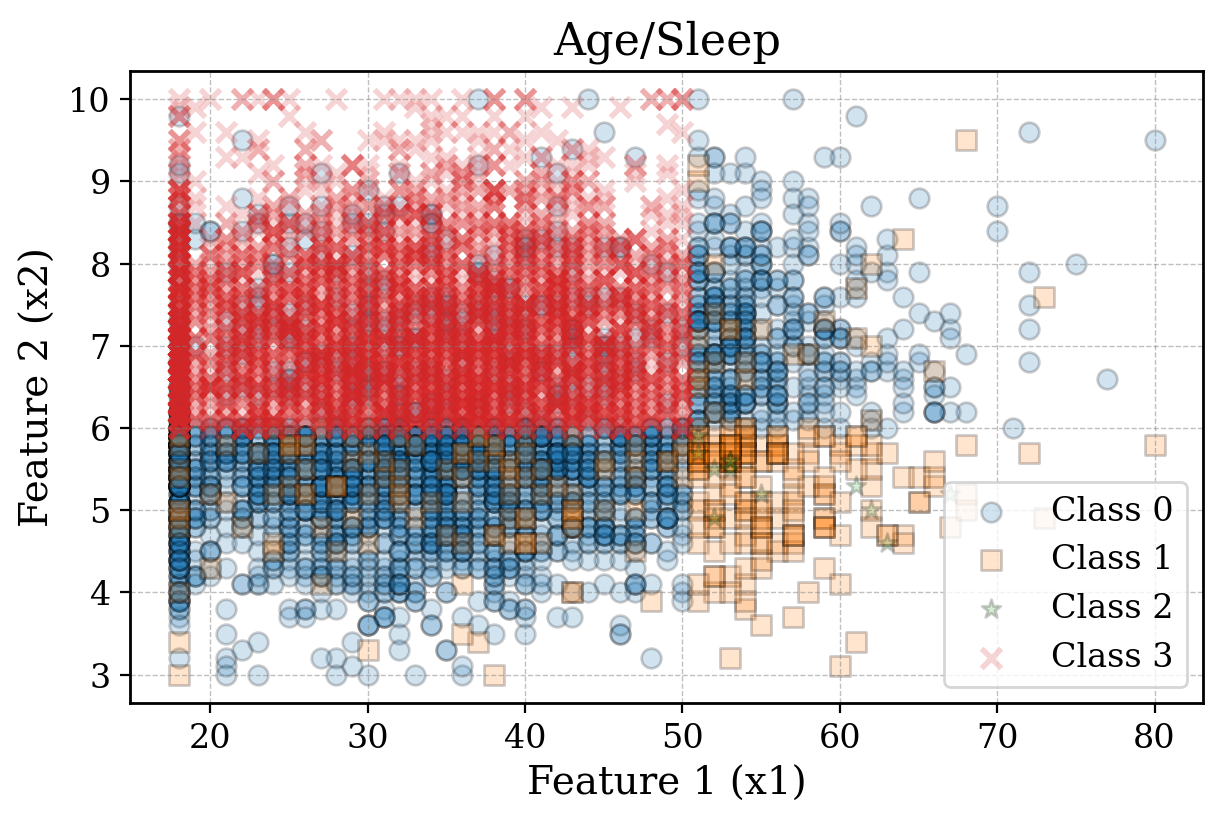

In [ ]:
X_train = train_df[["Age","Sleep_Hours"]].to_numpy(copy=True)
y_train = train_df["Health_Issues"].to_numpy(copy=True)

def visualize_data(x, y, title):
    plt.figure()
    
    classes = np.unique(y) # Get unique class labels

    for i, label in enumerate(classes):
        plt.scatter(
            x[y == label, 0],
            x[y == label, 1],
            marker=markers[i % len(markers)],
            color=colors[i], edgecolor="k" ,
            s=50, alpha=0.2, 
            label=f"Class {label}")

    plt.xlabel("Feature 1 (x1)")
    plt.ylabel("Feature 2 (x2)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_data(X_train,y_train,"Age/Sleep")

In [ ]:
#start with the visualization
#smoking and alcohol are boolean
#Gender Country and Sleep quality must be converted to numerals
"""Country could be hard to convert maybe we just sort them by GDP and give them descending numbers based on that or we use an index measuring health care. Coffee intake and estimated caffeine is redundent """
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  int64  
 3   Country                  10000 non-null  int64  
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  int64  
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  int64  
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            10000 non-null  int64  
 13  Occupation               10000 non-null  int64  
 14  Smoking                

ID           Age        Gender       Country  Coffee_Intake  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000     34.949100      0.522500      9.466800       2.509230   
std     2886.89568     11.160939      0.542884      5.740086       1.450248   
min        1.00000     18.000000      0.000000      0.000000       0.000000   
25%     2500.75000     26.000000      0.000000      4.000000       1.500000   
50%     5000.50000     34.000000      0.000000      9.000000       2.500000   
75%     7500.25000     43.000000      1.000000     14.000000       3.500000   
max    10000.00000     80.000000      2.000000     19.000000       8.200000   

        Caffeine_mg   Sleep_Hours  Sleep_Quality           BMI    Heart_Rate  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean     238.411010      6.636220       1.620700     23.986860     70.617800   
std      137.748815      1.222055       0.835525      3.906411      9.822951   
min        0.000000      3.000000       0.000000     15.000000     50.000000   
25%      138.750000      5.800000       1.000000     21.300000     64.000000   
50%      235.400000      6.600000       2.000000     24.000000     71.000000   
75%      332.025000      7.500000       2.000000     26.600000     77.000000   
max      780.300000     10.000000       3.000000     38.200000    109.000000   

       Stress_Level  Physical_Activity_Hours  Health_Issues   Occupation  \
count  10000.000000              10000.00000   10000.000000  10000.00000   
mean       1.108900                  7.48704       1.832000      1.98920   
std        0.537838                  4.31518       1.429678      1.40566   
min        0.000000                  0.00000       0.000000      0.00000   
25%        1.000000                  3.70000       0.000000      1.00000   
50%        1.000000                  7.50000       3.000000      2.00000   
75%        1.000000                 11.20000       3.000000      3.00000   
max        2.000000                 15.00000       3.000000      4.00000   

           Smoking  Alcohol_Consumption  
count  10000.00000         10000.000000  
mean       0.20040             0.300700  
std        0.40032             0.458585  
min        0.00000             0.000000  
25%        0.00000             0.000000  
50%        0.00000             0.000000  
75%        0.00000             1.000000  
max        1.00000             1.000000

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_21677/2198168833.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


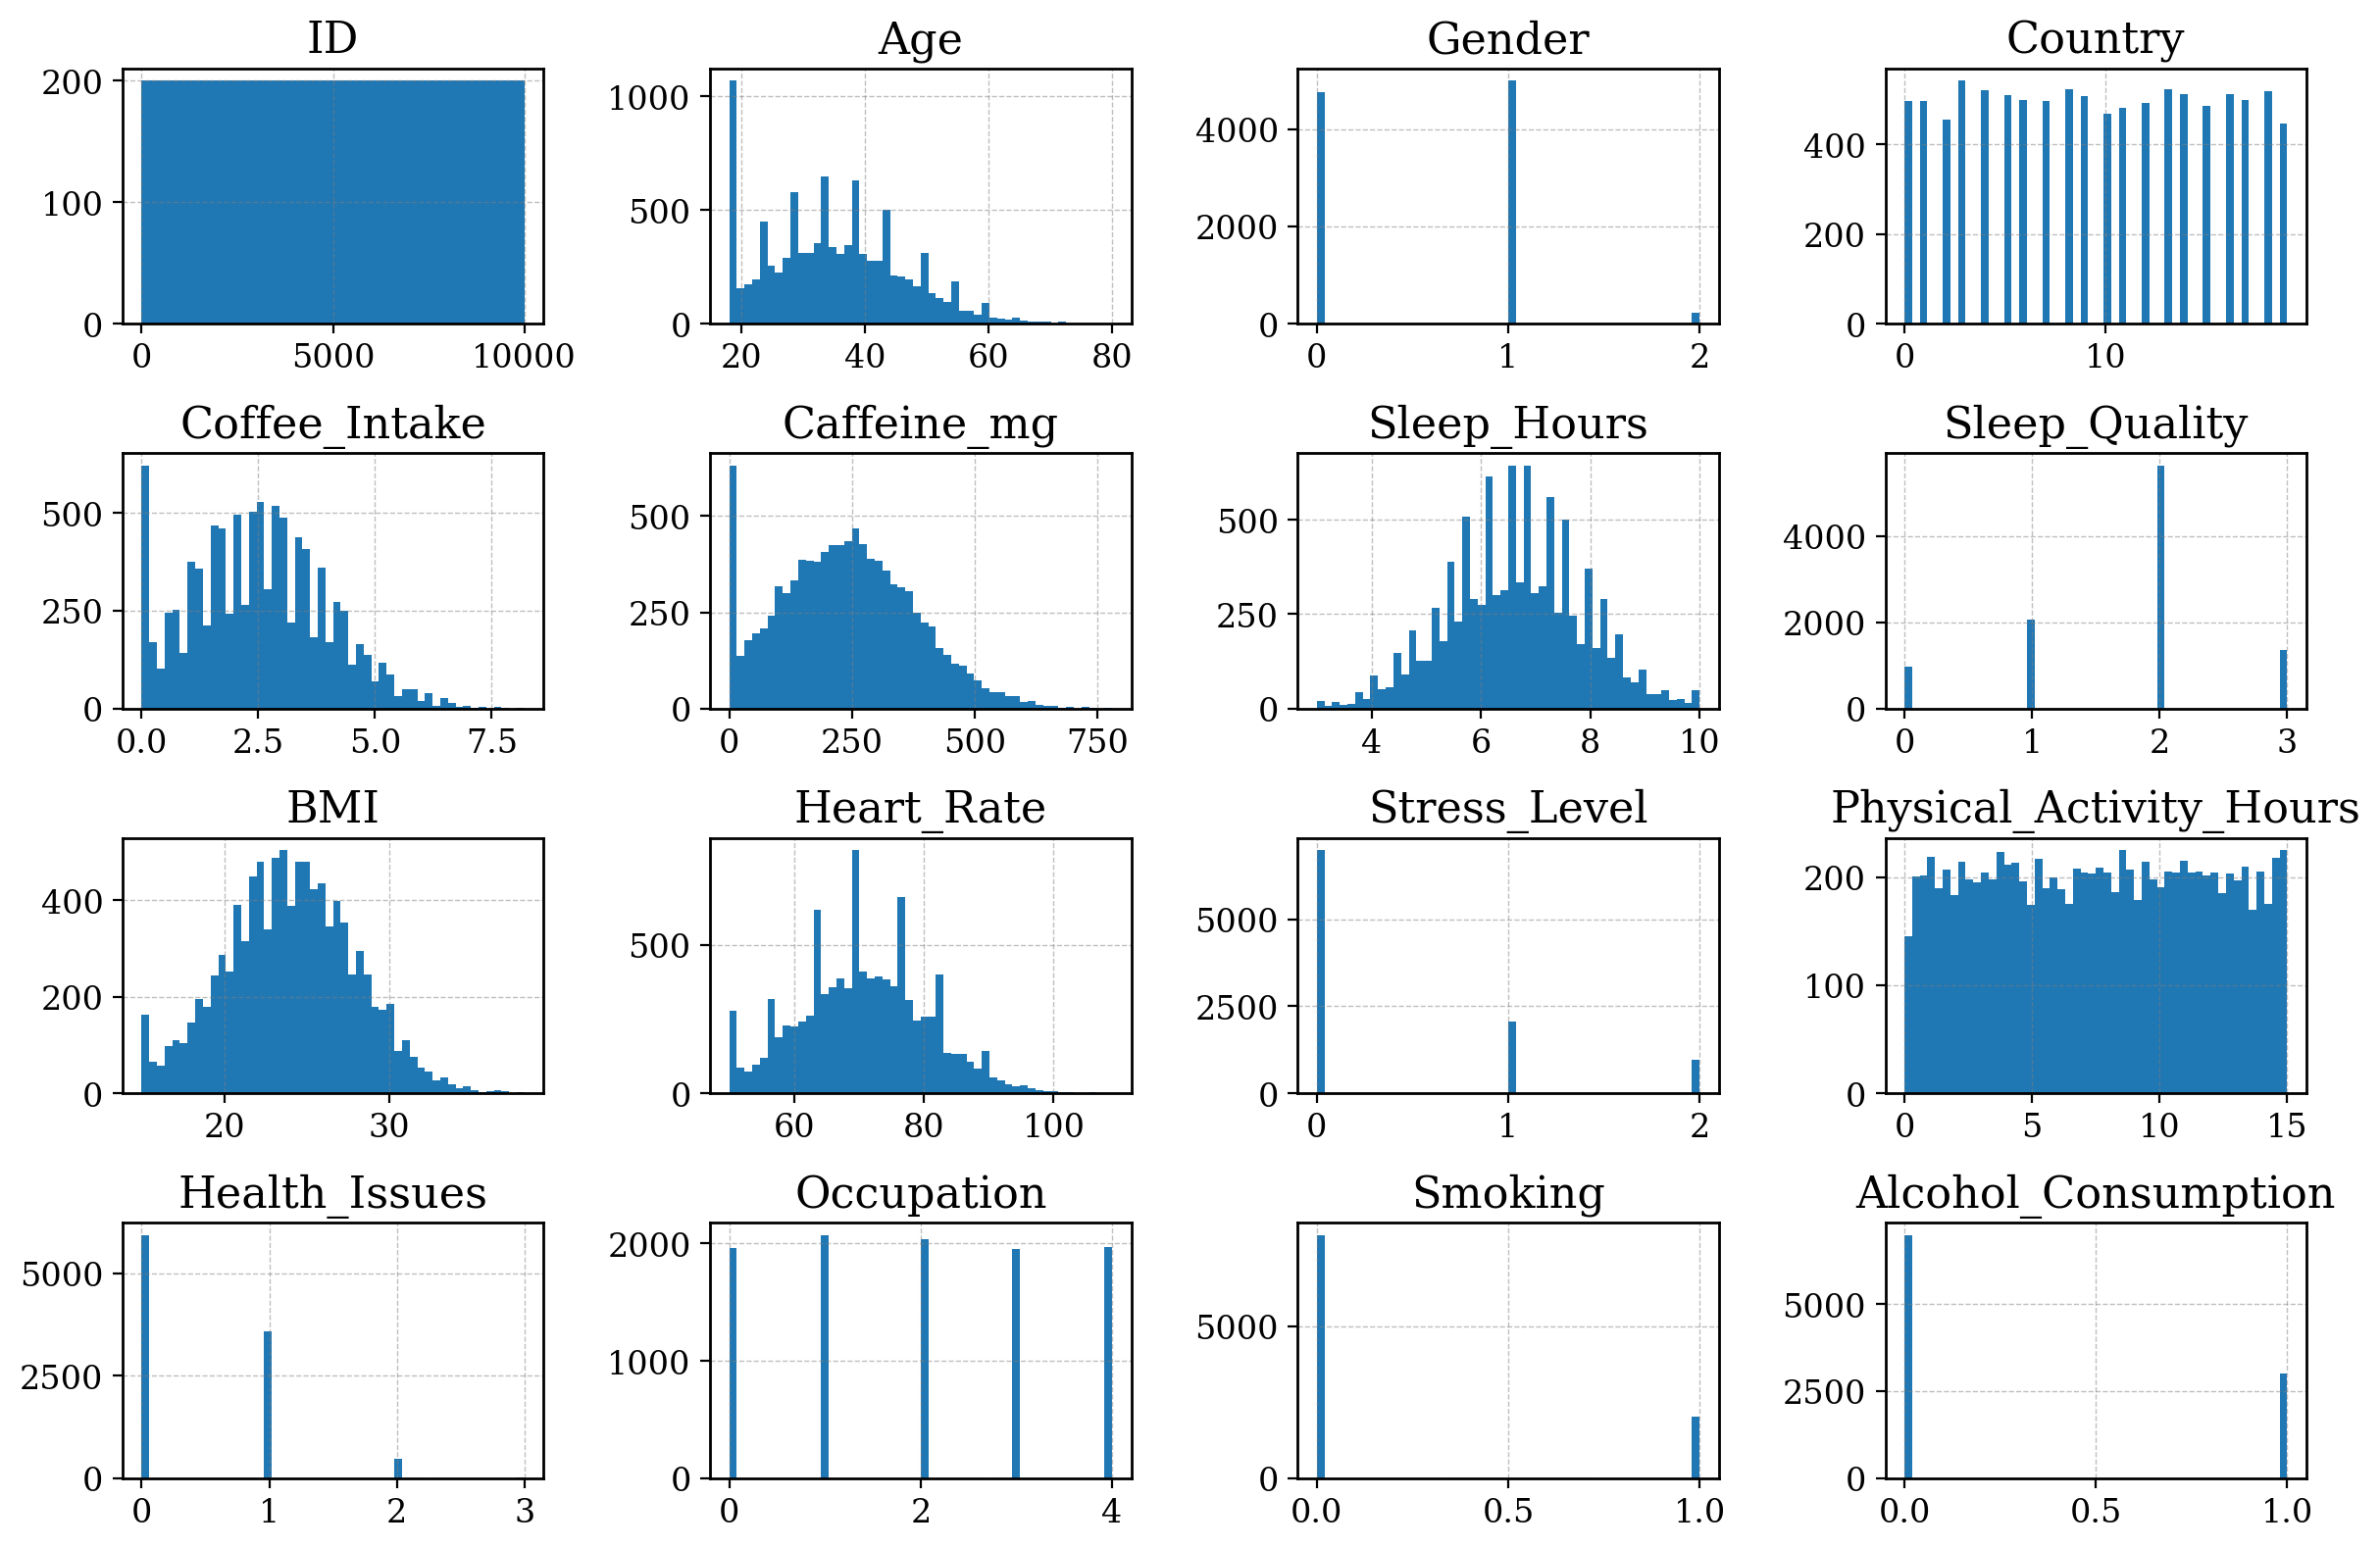

In [3]:
data.hist(bins=50, figsize=(12, 8))
plt.tight_layout()

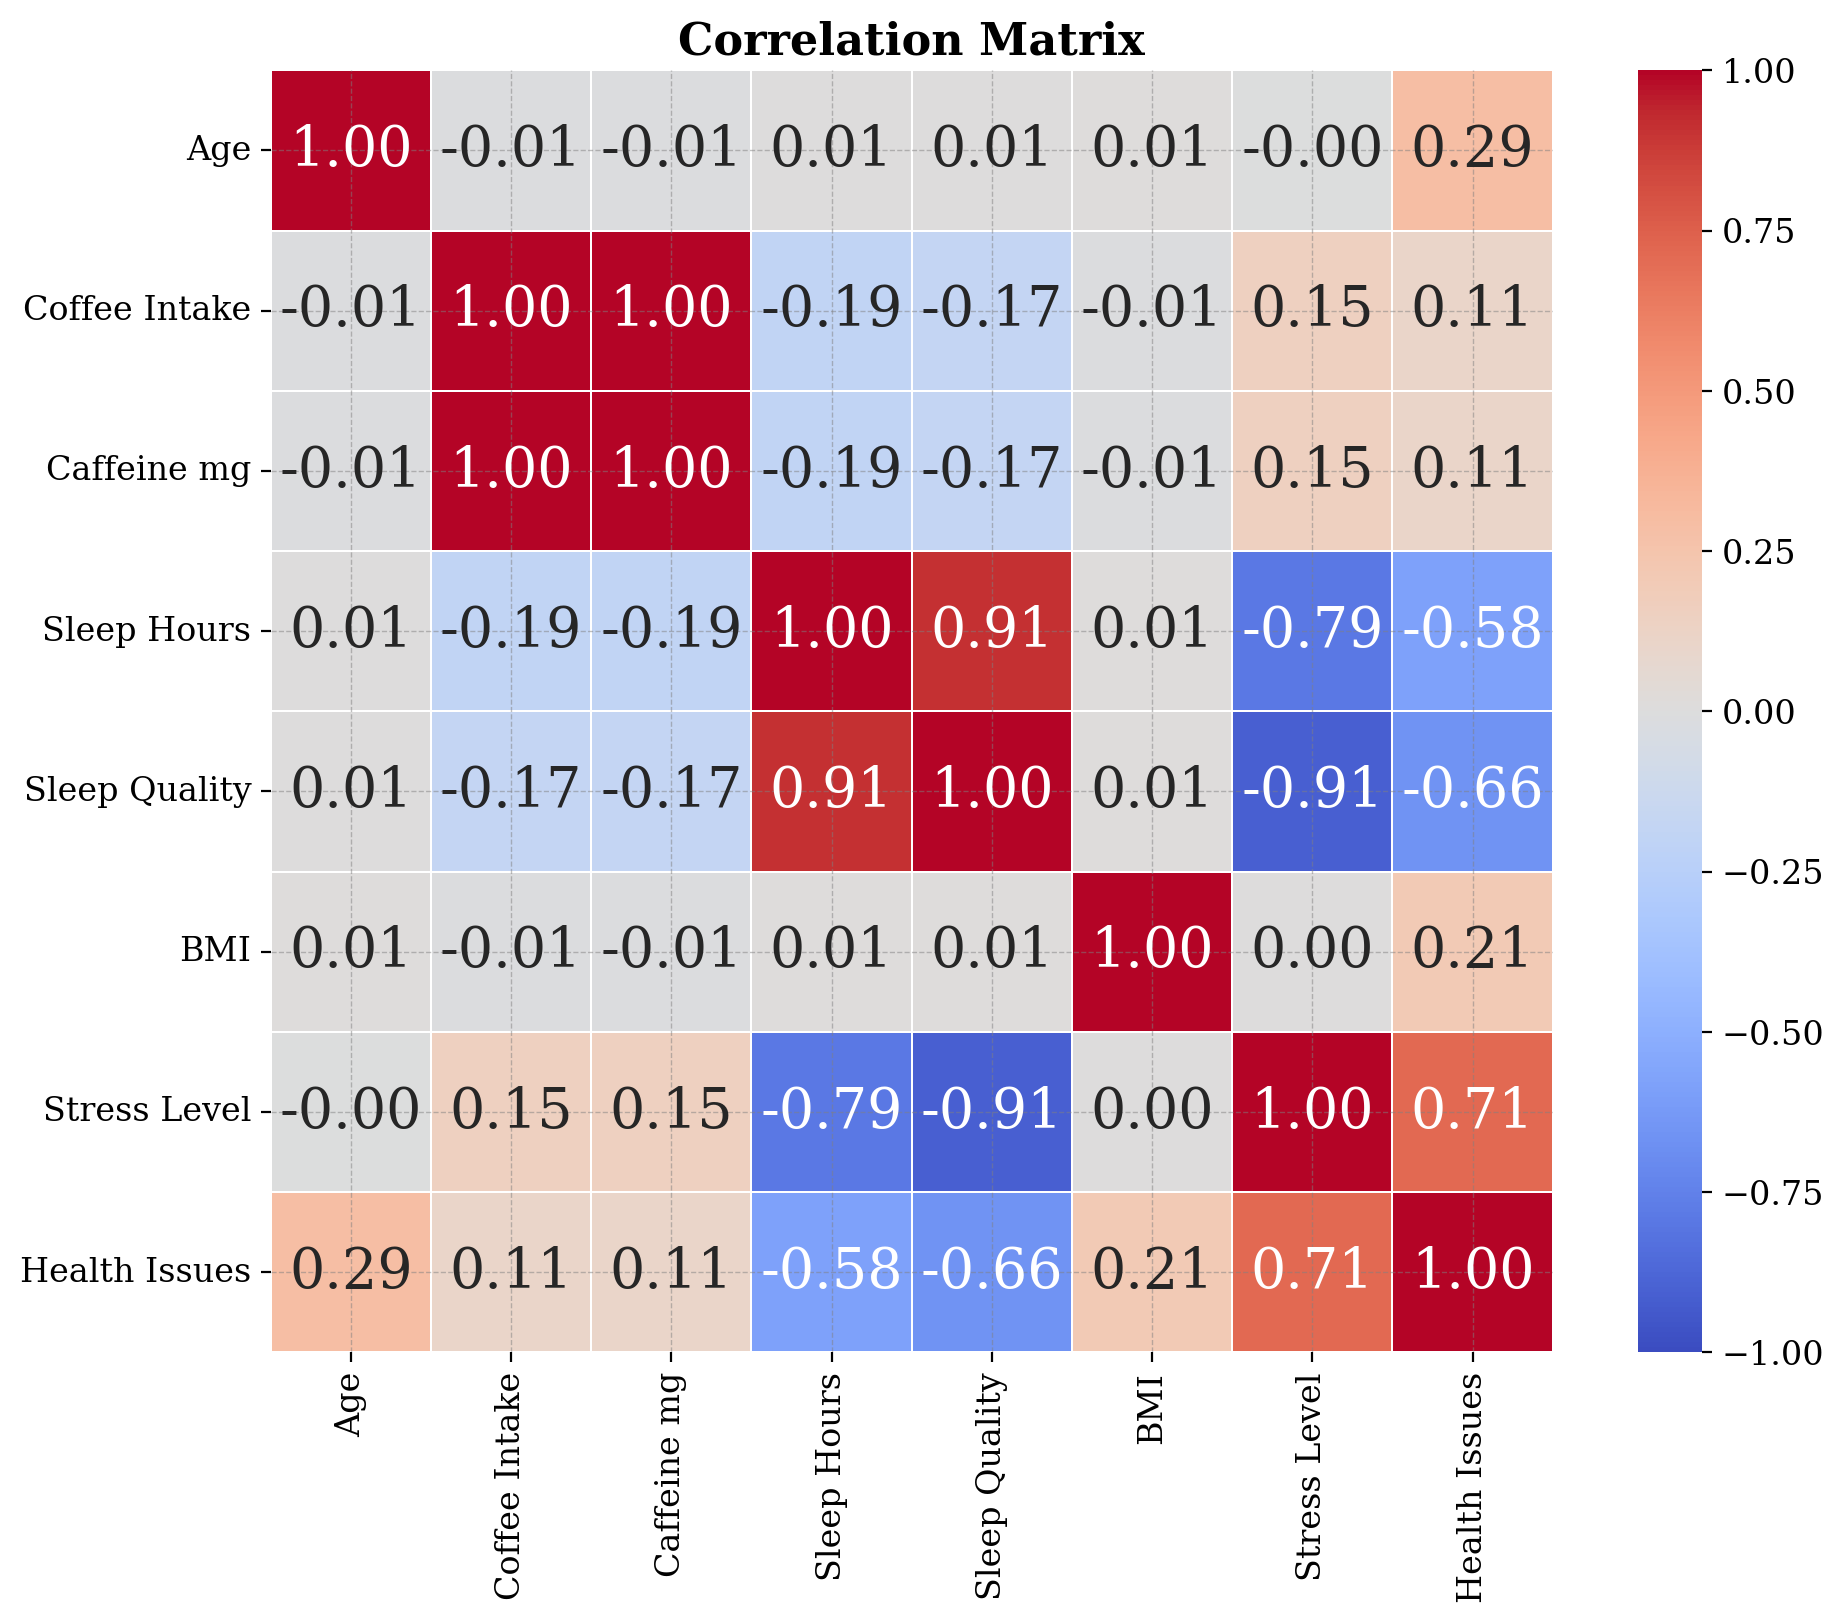

In [9]:
modified_df = data.rename(columns=lambda name: name.replace('_', ' ')).copy()

modified_df = modified_df.rename(columns={"Physical Activity Hours": "Phy. Act. Hours" , "Alcohol Consumption": "Alc. Cons."})

modified_df_corr = modified_df.drop(columns=["Gender", "Country", "Phy. Act. Hours", "Occupation", "Smoking", "Alc. Cons.", "Heart Rate"])

corr = modified_df_corr.corr(numeric_only=True)

# sns.set(font_scale=0.8, font="serif")
# Show heatmap
plt.figure(figsize=(10, 8))
g = sns.heatmap(corr,
            annot=True, fmt=".2f",
            vmax=1.0, vmin=-1.0,
            linewidths=0.1,
            cmap="coolwarm",
            annot_kws={'size': 20},
            square=True, cbar=True)
plt.title("Correlation Matrix", fontweight="bold")
#plt.tight_layout()
plt.savefig("corr_matrix.pdf")
plt.show()

Based on the correlation matrix, we can drop the features "Occupation", "Gender", "Country", "Alcohol", "Smoking" and "Physical Activity", since they are fully uncorrelated with all the other other features except themselve.

Furthermore, "Coffee" seems to be equivalent to "Caffeine intake", no surprise, so we can drop one of them as well.

Note: Between "Country" and "Smoking" seems to be a slight correlation, but nothing note worthy.

Main Target: "Health" (aka Classification problem)

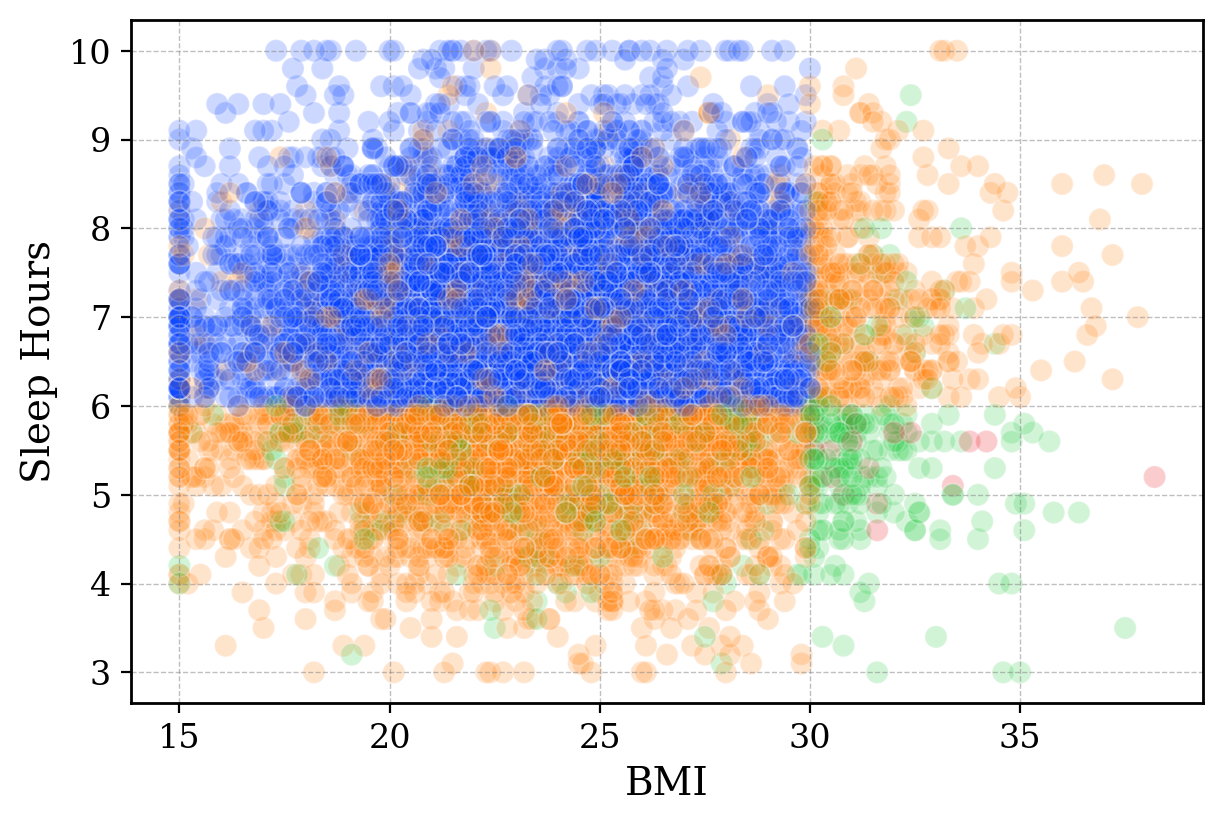

In [4]:
train_df_cont = modified_df[["Age", "Sleep Hours", "BMI", "Health Issues"]]

#labels = modified_df["Health Issues"]

hmm_dust = modified_df[train_df_cont["Health Issues"].isin([1,2])]        #filter for specific health_types

#g = sns.pairplot(train_df_cont, hue="Health Issues", diag_kind="kde", palette="bright", plot_kws={'alpha':0.3})

g = sns.scatterplot(train_df_cont, x="BMI", y = "Sleep Hours", hue="Health Issues", palette="bright", alpha = 0.2)

g.legend_.remove()
plt.savefig("pairplot.png", dpi=300)
plt.show()

In [ ]:
# Use the entire features for X_train and X_val

feature_names = train_df.select_dtypes(include=["number"]).drop(columns=["Health_Issues"]).columns

print(feature_names)

X_train = train_df[feature_names].values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val = val_df[feature_names].values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

Index(['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg',
       'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level',
       'Physical_Activity_Hours', 'Occupation', 'Smoking',
       'Alcohol_Consumption'],
      dtype='object')


/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_15809/2850078525.py:88: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


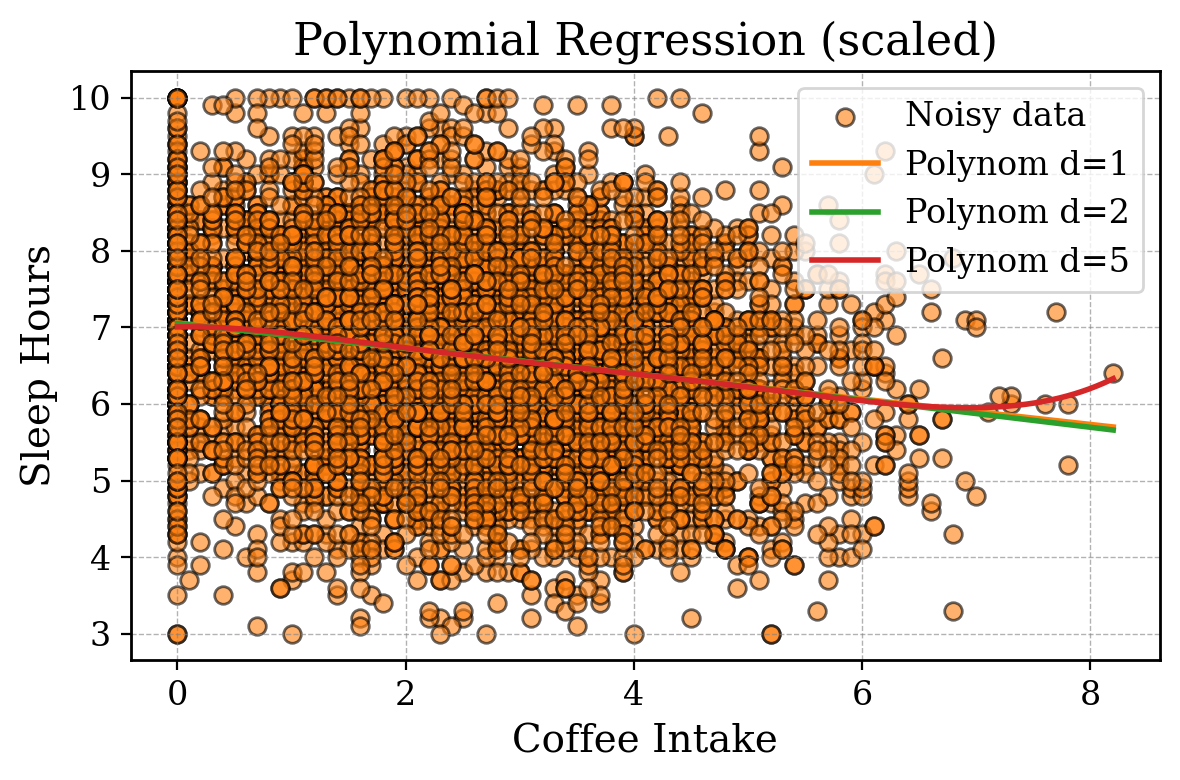

In [ ]:
coff_train, sleep_train = train_df["Coffee_Intake"].to_numpy(copy=True), train_df["Sleep_Hours"].to_numpy(copy=True)
coff_val , sleep_val = val_df["Coffee_Intake"].to_numpy(copy=True), val_df["Sleep_Hours"].to_numpy(copy=True)

# fig, ax = plt.subplots()

# ax.scatter(coff_train, sleep_train, alpha = 0.2)
# plt.show()

def plot_data(t, y_noisy, x_fit=None, y_fit=None, poly_degree=None, title="Projectile Motion"):
    # Use high dpi for high-quality output. 
    #  Usually any dpi between 200 and 300 is good for publications.
    #  Never use dpi<=100. The default for dpi in plt.figure() is 100.
    # My recommendation is dpi=300, especially for reports and publications, 
    # however, dpi=300 may create larger file sizes, and large figures on your screen, 
    # but you can try ...!
    plt.figure(figsize=(6, 4), dpi=200)

    # Plot the noisy data
    # Use scatter plot to visualize data distribution, and remember to use alpha<1.0 for transparency.
    # If the reason for alpha<1 is not clear for you, ask me or discuss it with your friends.
    plt.scatter(t, y_noisy, color=colors[1], s=40, edgecolors="k", alpha=0.6, label=f"Noisy data")

    # Plot the polynomial regression fit if provided
    if (x_fit is not None and 
        y_fit is not None):
        label_text = f"Polynomial degree {poly_degree}" if poly_degree is not None else "Regression fit"
        plt.scatter(x_fit, y_fit, color=colors[2], s=2, label=label_text)

    # Customize plot appearance
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Displacement (m)", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True, linestyle="--", color="grey", linewidth=0.5, alpha=0.6)
    plt.tight_layout() # Fit all elements within the figure area
    plt.show()

def fit_polynomial_sklearn(x, y, degree=2, normalize=True):
    if normalize:
        # Create a pipeline with normalization
        model = make_pipeline(StandardScaler(), 
                              PolynomialFeatures(degree), 
                              LinearRegression())
    else:
        # Create a pipeline without normalization
        model = make_pipeline(PolynomialFeatures(degree), 
                              LinearRegression())

    # We need to use x.reshape, as required by sklearn
    model.fit(x.reshape(-1, 1), y)
    return model

# Predict polynomial values at new input data using the trained model
def predict_polynomial_sklearn(model, x_vals):
    return model.predict(x_vals.reshape(-1, 1))

# Print the coefficients of the trained sklearn model from the pipeline
def print_model_coefficients(model):
    lr = model.named_steps['linearregression']
    coef = lr.coef_
    intercept = lr.intercept_

    print(f"Intercept: {intercept:.4f}")
    for i, c in enumerate(coef):
        print(f"w_{i}: {c:.4f}")
        
def plot_multiple_fits(t, y_noisy, degrees, normalize=True, title="Polynomial Regression (scaled)"):
    plt.figure(figsize=(6, 4), dpi=200)

    # Plot noisy data
    plt.scatter(t, y_noisy, color=colors[1], s=40, edgecolors="k", alpha=0.6, label="Noisy data")

    # Generate dense grid for smooth predictions
    t_vals = np.linspace(min(t), max(t), 3*t.size)

    # Plot polynomial fits for each degree
    for idx, deg in enumerate(degrees):
        model  = fit_polynomial_sklearn(t, y_noisy, degree=deg, normalize=normalize)
        y_pred = predict_polynomial_sklearn(model, t_vals)
        color  = colors[idx + 1]  # offset by 1 since colors[0] used for true y
        plt.plot(t_vals, y_pred, color=color, linewidth=2, label=f"Polynom d={deg}")

    plt.xlabel("Coffee Intake", fontsize=14)
    plt.ylabel("Sleep Hours", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True, linestyle="--", color="grey", linewidth=0.5, alpha=0.6)    
    plt.tight_layout()
    plt.show()

# ========== MAIN ==========
# Fit polynomial regression models and plot
degrees = [1, 2, 5] # degrees of the polynomial
model = plot_multiple_fits(coff_train, sleep_train, degrees, normalize=False)
for i in degrees:
    hmm = fit_polynomial_sklearn(coff_train, sleep_train, i, normalize=False)
    #print("Polyonomial of degree {}".format(i)+",")
    #print_model_coefficients(hmm)
    #print("\n")

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_15809/260806441.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


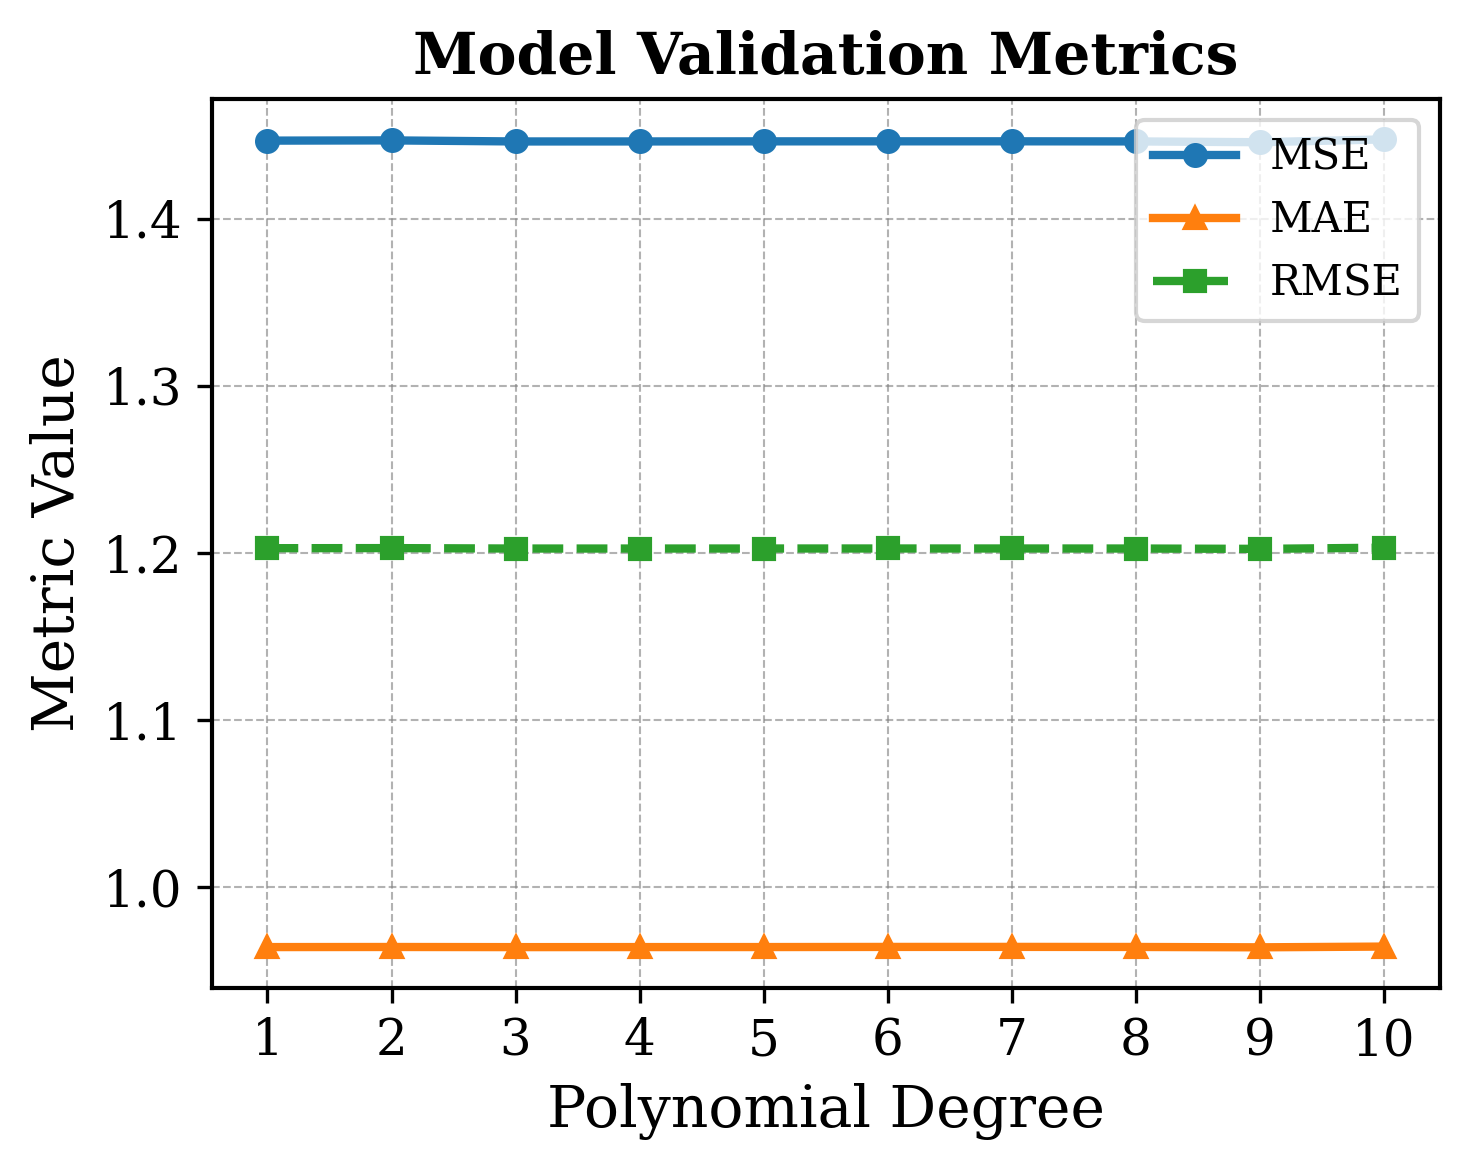

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Function to validate models and plot the results
# This functions evaluates the performance of polynomial regression models.
# It computes metrics like MSE, MAE, and RMSE for each model.
# Its input includes the feature matrix (x), true target values (y_true),
# a list of trained models, and their corresponding polynomial degrees.
def validate_poly_models(x, y_true, models, degrees):
    mse_values  = []
    mae_values  = []
    rmse_values = []

    for model in models:
        # Predict y values using the model
        y_pred = model.predict(x[:, np.newaxis])

        mse  = mean_squared_error(y_true, y_pred)       # Calculate MSE
        mae  = mean_absolute_error(y_true, y_pred)       # Calculate MAE
        rmse = root_mean_squared_error(y_true, y_pred)   # Calculate RMSE

        # Store the metrics for plotting
        mse_values.append(mse)
        mae_values.append(mae)
        rmse_values.append(rmse)

    plt.figure(figsize=(5, 4), dpi=300)

    # Plot metrics
    # Note: For better visualization, I use a logarithmic scale for the y-axis.
    plt.semilogy(degrees, mse_values , marker="o", markersize=5, color=colors[0], linestyle="-" , label="MSE" )
    plt.semilogy(degrees, mae_values , marker="^", markersize=5, color=colors[1], linestyle="-" , label="MAE" )
    plt.semilogy(degrees, rmse_values, marker="s", markersize=5, color=colors[2], linestyle="--", label="RMSE")

    # Set x-ticks
    plt.xticks(degrees)

    # Plot
    plt.xlabel("Polynomial Degree", fontsize=14)
    plt.ylabel("Metric Value", fontsize=14)
    plt.title("Model Validation Metrics", fontsize=14, weight="bold") # Here I show how to bold the title
    plt.legend(fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle="--", color="grey", linewidth=0.5, alpha=0.6)
    plt.yscale("linear")
    plt.tight_layout()
    plt.show()

# ========== MAIN ==========
# degrees of the polynomial
# We give these as input to our training model
degrees = np.linspace(1, 10, 10, dtype=int)

# We train data with different polynomial degrees and return the models into 
#  an array for use in the validation function.
models  = [fit_polynomial_sklearn(coff_train, sleep_train, degree) for degree in degrees]

# Validate the models and show the metrics
validate_poly_models(coff_val, sleep_val, models, degrees)

Degree 1: Avg RMSE = 1.197027
Degree 2: Avg RMSE = 1.197146
Degree 3: Avg RMSE = 1.197106
Degree 4: Avg RMSE = 1.197234
Degree 5: Avg RMSE = 1.197330
Degree 6: Avg RMSE = 1.197424
Degree 7: Avg RMSE = 1.197506
Degree 8: Avg RMSE = 1.197605
Degree 9: Avg RMSE = 1.197749
Degree 10: Avg RMSE = 1.198122


/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_15809/1205541604.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


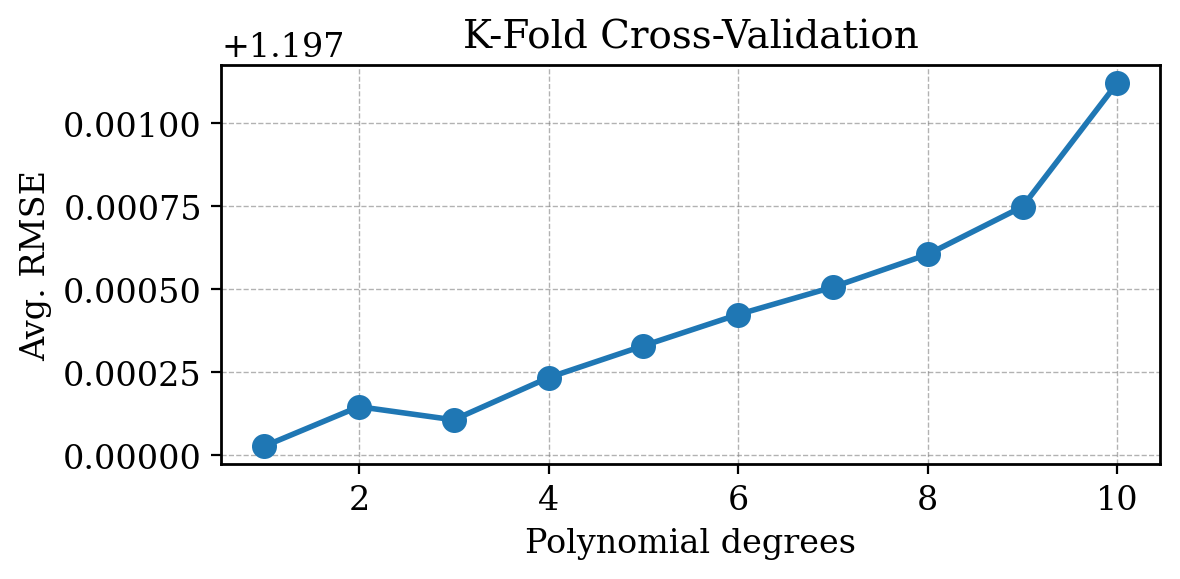

In [ ]:
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit

# This function performs k-fold cross-validation for a given model function (polynomial) 
# and a set of degrees. The inputs are the feature matrix (x), target values (y), 
# the model function, a list of polynomial degrees, and the number of folds (k).
def cross_validation_kfold(x, y, model_function, degrees, k):
    # KFold splitter. 
    # Shuffling the data is crucial here)!

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    #kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    #kf = ShuffleSplit(n_splits=k, test_size=0.3, random_state=42)
    #kf = StratifiedShuffleSplit(n_splits=k, test_size=0.3, random_state=42)

    results = { degree: [] for degree in degrees }  # Store RMSE for each degree

    # Iterate over each polynomial degree
    for degree in degrees:
        for train_idx, val_idx in kf.split(x):
            # Split data into training and validation
            x_train, x_val = x[train_idx], x[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Train the model on the current k-th fold of data and for the d-th degree polynomial
            model = model_function(x_train, y_train, degree)
            
            # Predict on validation set
            y_pred = model.predict(x_val.reshape(-1, 1))
            
            # Compute RMSE and store
            rmse = root_mean_squared_error(y_val, y_pred)
            results[degree].append(rmse)
    
    # Compute average RMSE for each degree
    avg_rmse = {degree: np.mean(rmses) for degree, rmses in results.items()}
    return avg_rmse

# Visualize cross-validation results
def plot_validation_results(degrees, avg_rmse):
    plt.figure(figsize=(6, 3), dpi=200)
    plt.plot(degrees, [avg_rmse[degree] for degree in degrees], 
             marker="o", linestyle="-", color=colors[0])
    plt.xlabel("Polynomial degrees", fontsize=12)
    plt.ylabel("Avg. RMSE", fontsize=12)
    plt.title("K-Fold Cross-Validation", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

x = data["Coffee_Intake"].to_numpy(copy=True)
y_noisy = data["Sleep_Hours"].to_numpy(copy=True)

degrees = np.linspace(1, 10, 10, dtype=int)

# Perform k-fold cross-validation
avg_rmse = cross_validation_kfold(x, y_noisy, 
                                  model_function=fit_polynomial_sklearn, 
                                  degrees=degrees, 
                                  k=100)

# Print average RMSE for each degree
for degree, rmse in avg_rmse.items():
    print(f"Degree {degree}: Avg RMSE = {rmse:.6f}")

# Plot results
plot_validation_results(degrees, avg_rmse)

In [12]:
# Use the entire features for X_train and X_val

drop_feat = ["Health_Issues"]

feature_names = train_df.select_dtypes(include=["number"]).drop(columns=drop_feat).columns

print(feature_names)

X_train = train_df[feature_names].values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val = val_df[feature_names].values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

Index(['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg',
       'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level',
       'Physical_Activity_Hours', 'Occupation', 'Smoking',
       'Alcohol_Consumption'],
      dtype='object')


Best Parameters from RandomizedSearchCV: {'full_dt_regressor__max_depth': 5, 'full_dt_regressor__min_samples_leaf': 4, 'full_dt_regressor__min_samples_split': 7}
Decision Tree regression metrics:

Cross-Validated Accuracy-Score: [0.99333333 1.         0.99666667 0.99666667 0.99666667 1.
 1.         1.         1.         1.        ]
Average Cross-Validated Accuracy: 0.9983


/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


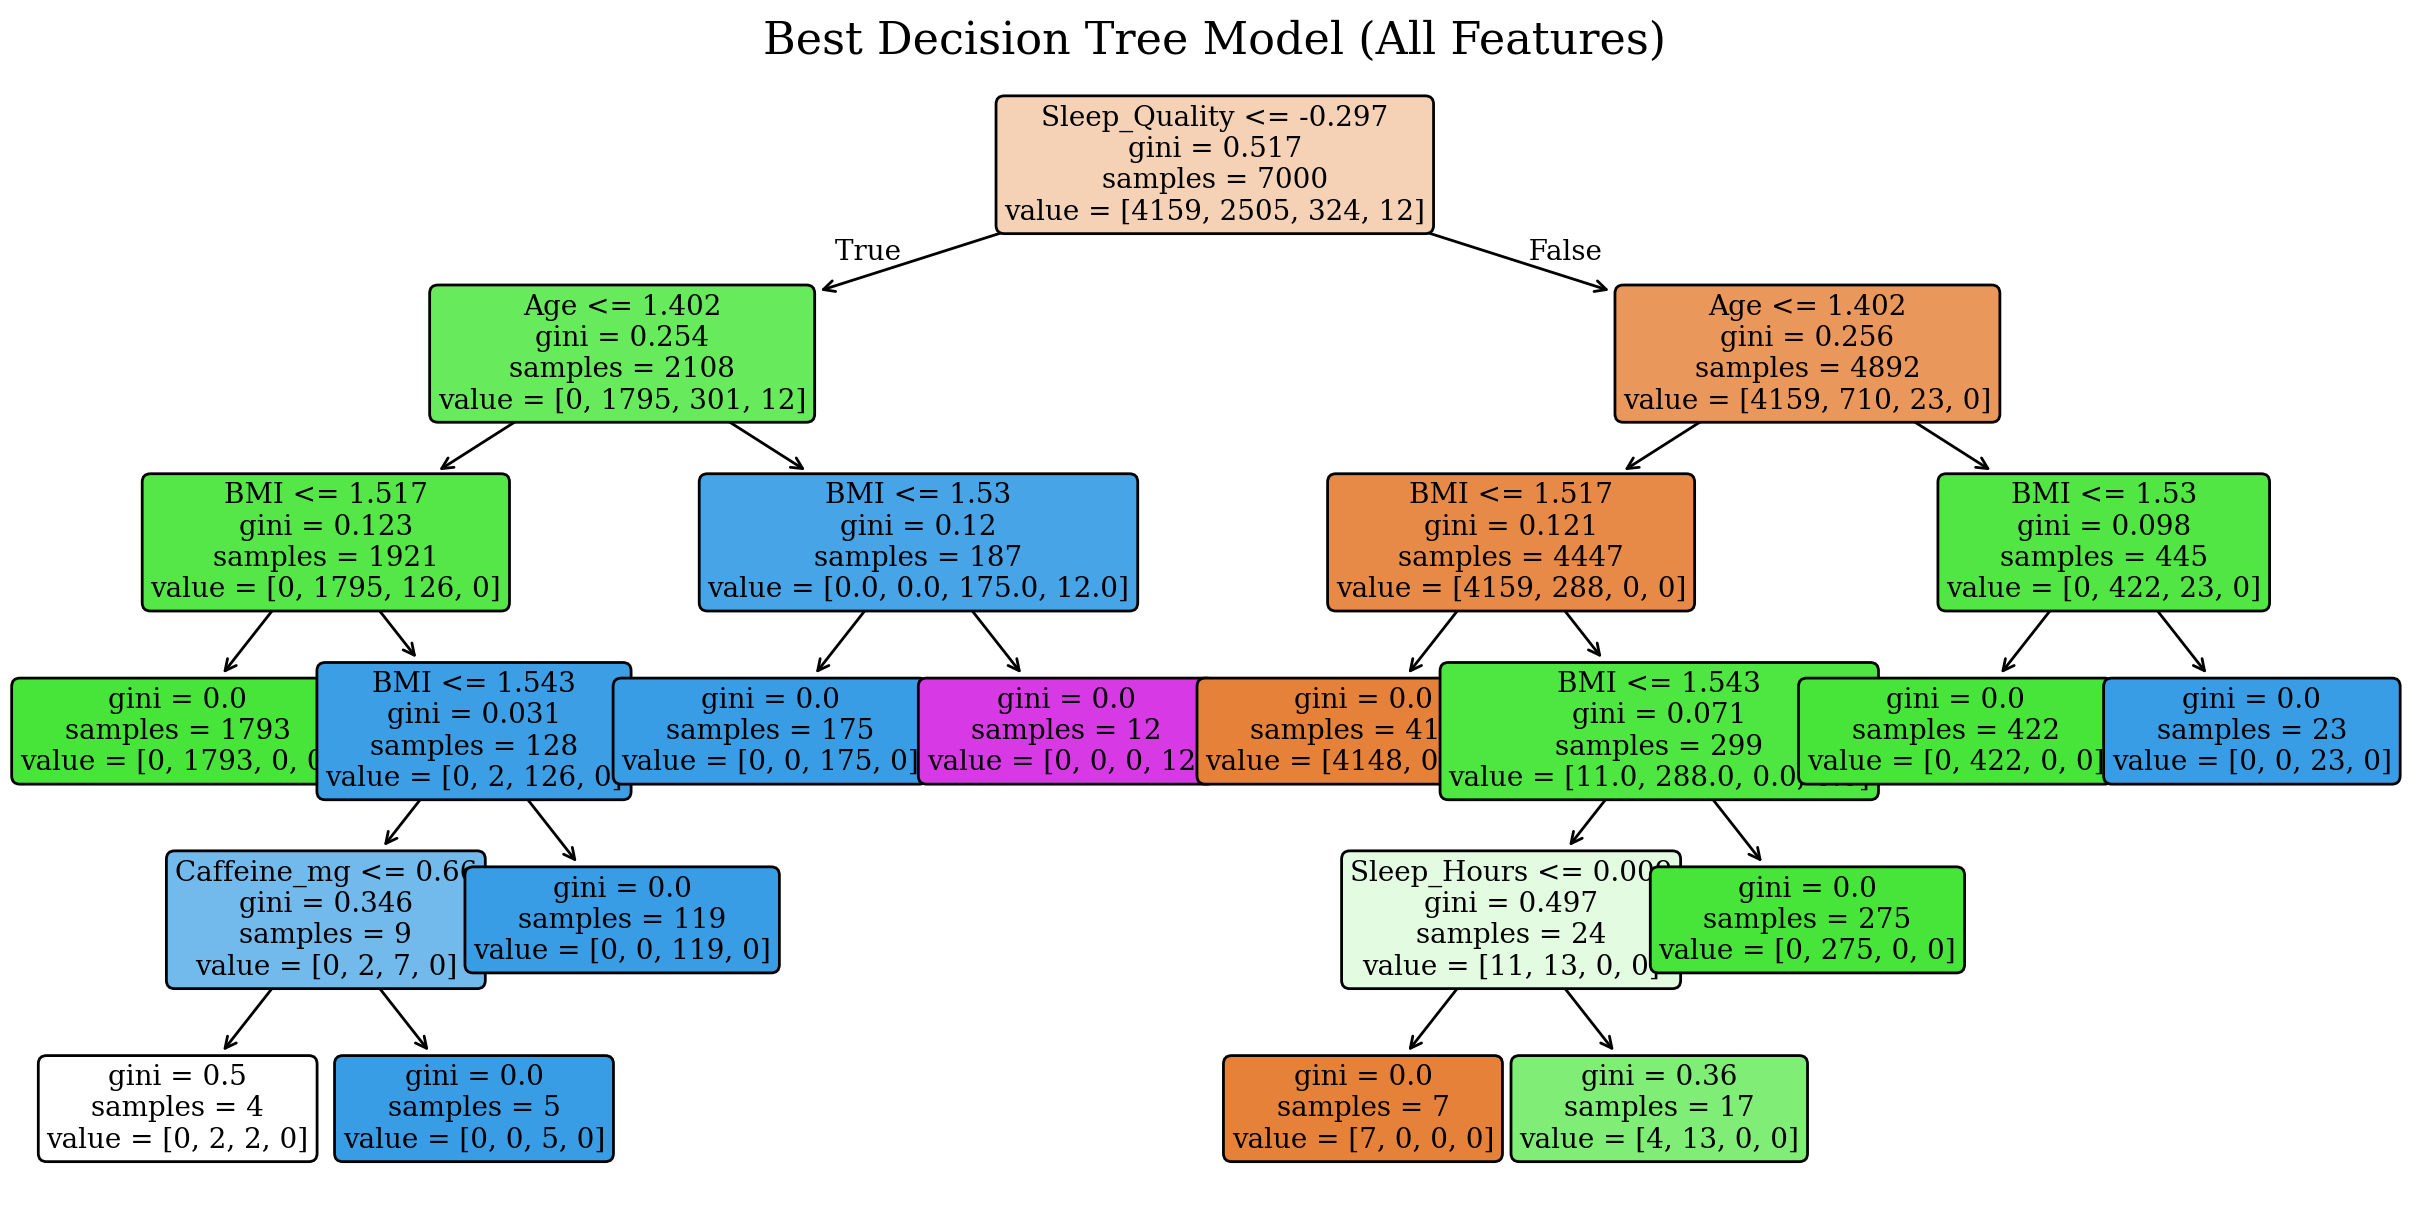

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      1.00      1.00      1074
           2       0.99      0.99      0.99       139
           3       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Confusion Matrix: 
 [[1781    1    0    0]
 [   0 1073    1    0]
 [   0    2  137    0]
 [   0    0    0    5]]


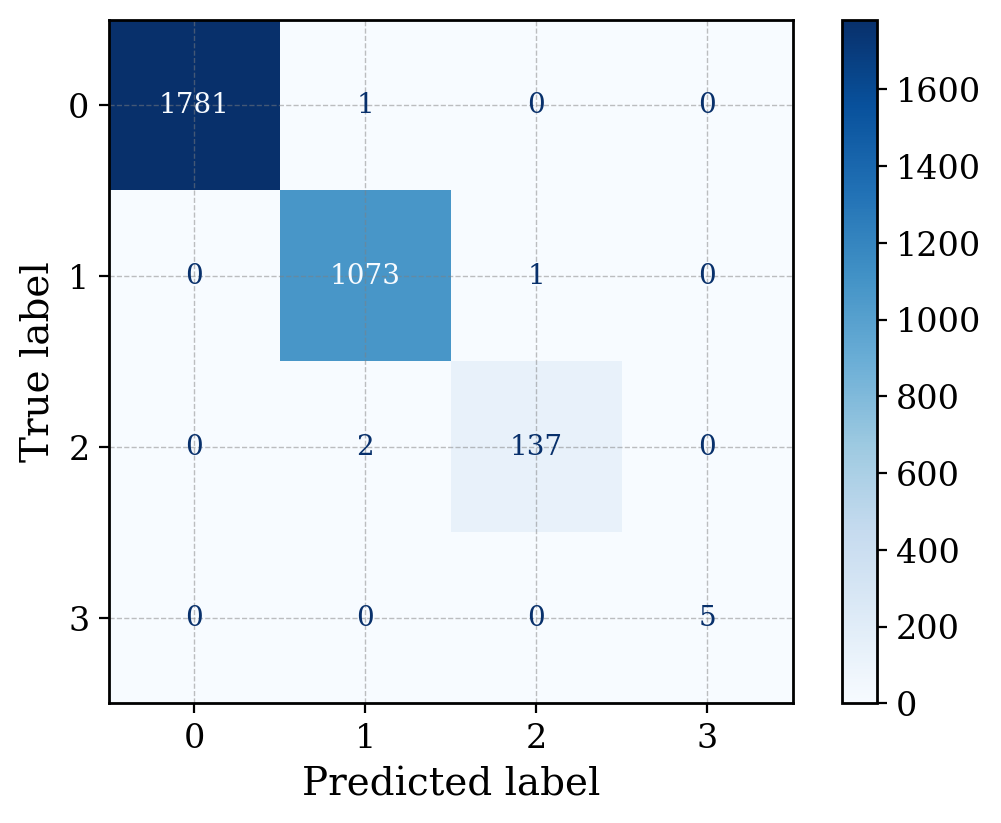

In [19]:
# Build pipeline
new_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('full_dt_regressor', DecisionTreeClassifier(random_state=42))  # Train Decision Tree Regressor
])

# Hyperparameter search space
param_distributions = {
    'full_dt_regressor__max_depth'        : randint(2, 10),
    'full_dt_regressor__min_samples_split': randint(2, 10),
    'full_dt_regressor__min_samples_leaf' : randint(1, 10)
}

# Randomized search with cross-validation
search = RandomizedSearchCV(
    estimator=new_pipeline,   # Use the new pipeline
    param_distributions=param_distributions, # Hyperparameter search space
    n_iter       = 100,    # Number of iterations for random search
    cv           = 5,     # Cross-validation folds
    scoring      = 'accuracy',  # Scoring metric for evaluation
    n_jobs       = -1,    # Use all available CPU cores
    random_state = 42,    # Random state for reproducibility
)

# Fit search
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Predict on validation set
y_pred = best_model.predict(X_val)


print("Best Parameters from RandomizedSearchCV:", search.best_params_)
print("Decision Tree regression metrics:")

# Cross-validation with best model
cv_scores = cross_val_score(best_model, X_val, y_val, cv=10, scoring='accuracy')
print(f"\nCross-Validated Accuracy-Score: {cv_scores}")
print(f"Average Cross-Validated Accuracy: {cv_scores.mean():.4f}")

# Visualize the Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(best_model.named_steps['full_dt_regressor'], feature_names=train_df[feature_names].columns,
          filled=True,
          rounded=True,
          max_depth=10,  # You can remove or increase this if the tree is shallow
          fontsize=10)
plt.title("Best Decision Tree Model (All Features)")
plt.show()

print(classification_report(y_val,y_pred))

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", cm)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
#plt.title("Confusion Matrix (DT)")
plt.savefig("DT.png", dpi=300)
plt.show()    

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_67602/822173231.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modified_df.drop(columns=["Health Issues"]).columns, rotation=90)


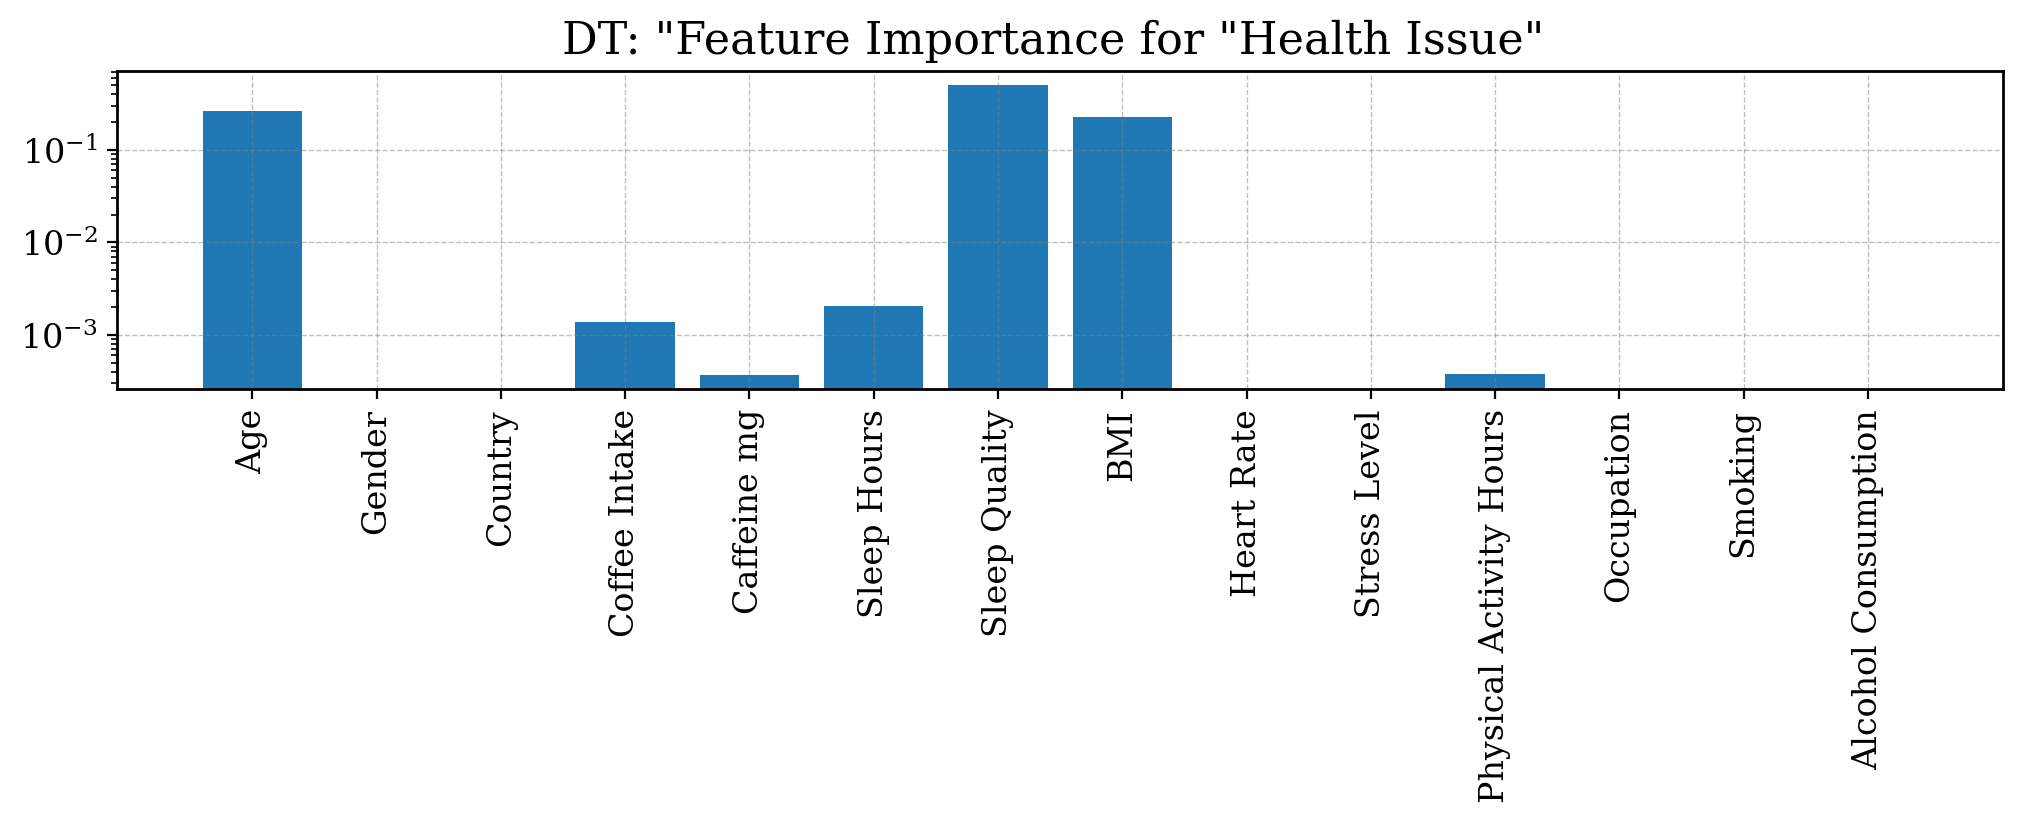

In [26]:
new_pipeline.fit(X_train, y_train)

hmm = new_pipeline.named_steps['full_dt_regressor'].feature_importances_

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(train_df.drop(columns=drop_feat).columns,hmm,log=True)
ax.set_xticklabels(modified_df.drop(columns=["Health Issues"]).columns, rotation=90)
plt.title("DT: \"Feature Importance for \"Health Issue\" ")
plt.savefig("dt_feature_importance.pdf")
plt.show()

--> We can drop "ID", "Gender", "Occupation", "Smoking", "Alcohol_Consumption", "Physical_Activity_Hours", "Sleep_Quality" and "Coffee_Intake".

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_15809/410401068.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


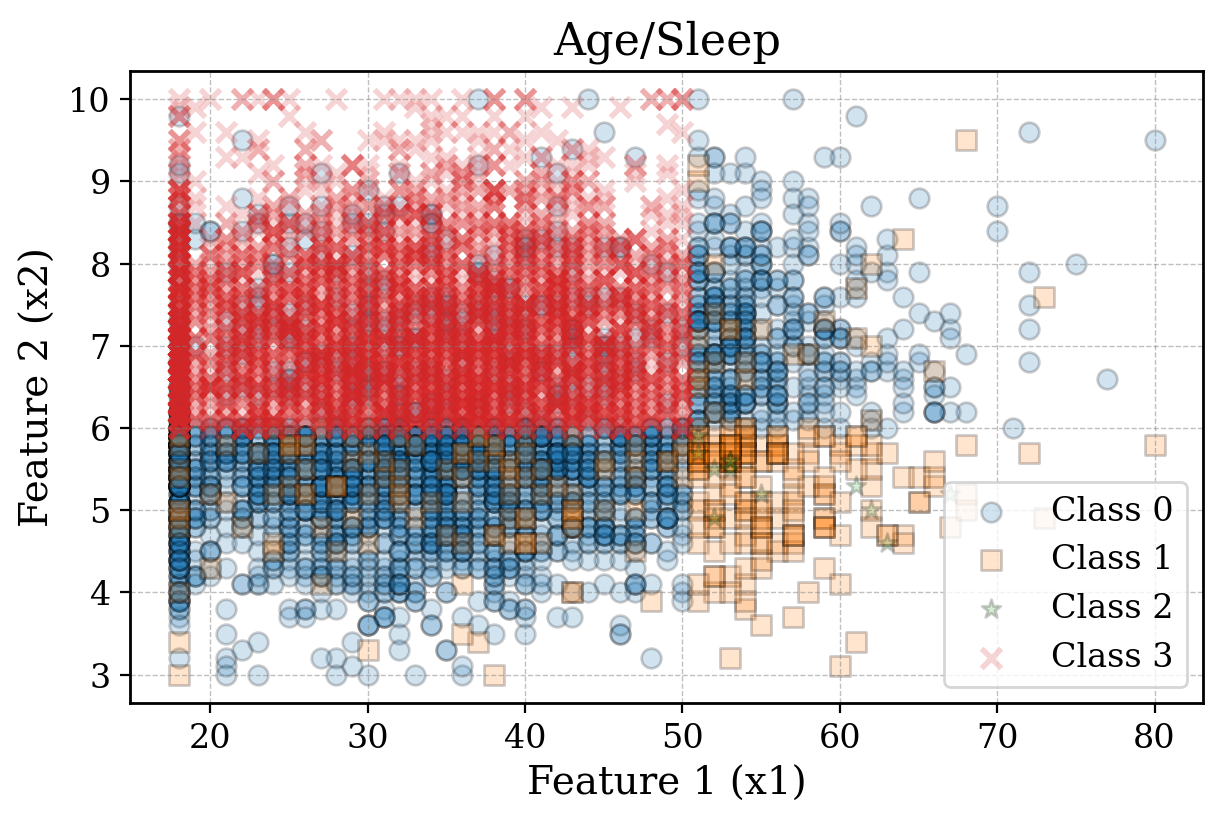

In [ ]:
#KNN here for features Age/Sleep_Hours and label Health_Issues

X_train = train_df[["Age","Sleep_Hours"]].to_numpy(copy=True)
y_train = train_df["Health_Issues"].to_numpy(copy=True)

X_val = val_df[["Age","Sleep_Hours"]].to_numpy(copy=True)
y_val = val_df["Health_Issues"].to_numpy(copy=True)

visualize_data(X_train,y_train,"Age/Sleep")

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_15809/970715754.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


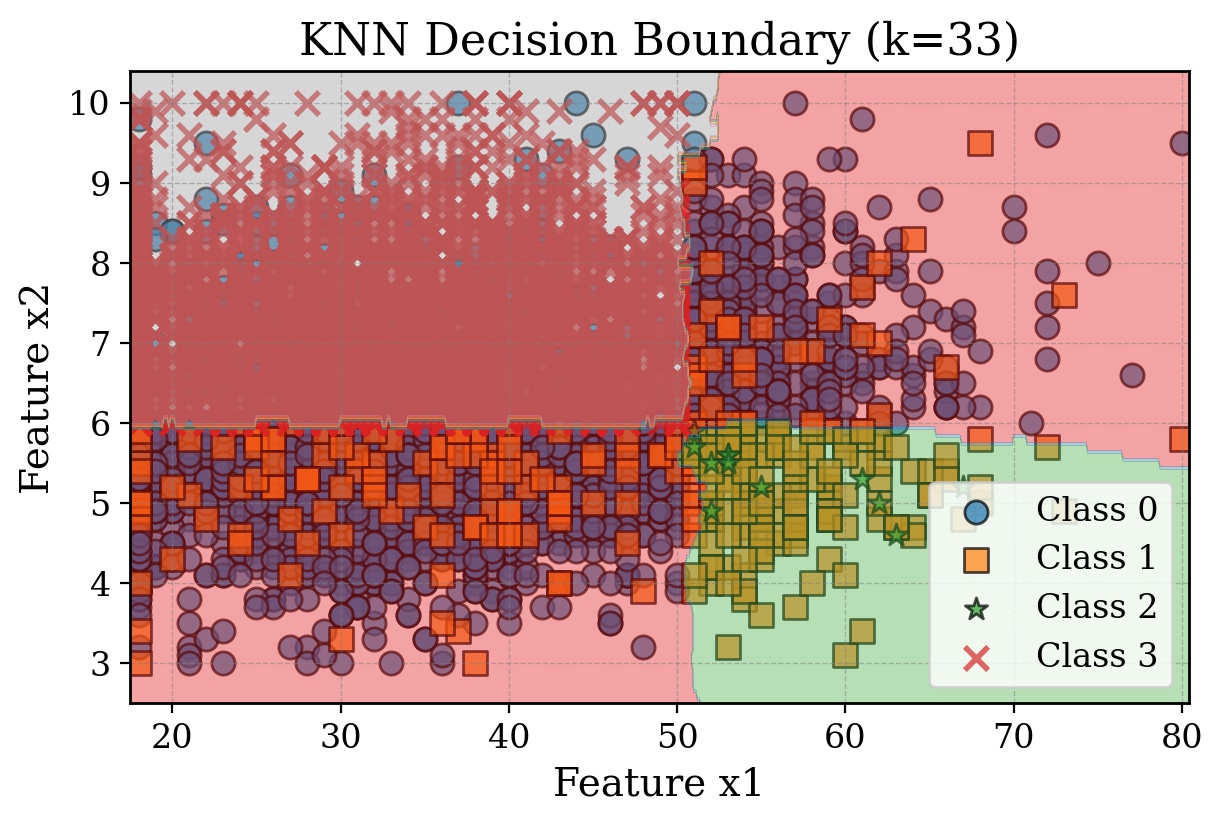

In [ ]:
X = X_train.copy()

k = 33

# Train a KNN classifier
knn = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])

knn.fit(X_train, y_train)

# Create meshgrid for decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on meshgrid
y_pred = knn.predict(np.c_[xx.ravel(), yy.ravel()])
y_pred = y_pred.reshape(xx.shape)

# Plot decision boundary
plt.figure()

# Plot each class dynamically
for i, class_label in enumerate(np.unique(y_train)):
    plt.scatter(
        X_train[y_train == class_label][:, 0], 
        X_train[y_train == class_label][:, 1],
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        s=70, edgecolor='k', alpha=0.7,
        label=f'Class {class_label}'
    )

plt.contourf(xx, yy, y_pred, alpha=0.4, cmap='Set1')

plt.xlabel('Feature x1')
plt.ylabel('Feature x2')
plt.title(f"KNN Decision Boundary (k={k})")
plt.legend()
plt.show()

In [ ]:
hmm = list(range(1,101,2))
acc = []
for k in hmm:
    # Train a KNN classifier
    knn = Pipeline([
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])

    knn.fit(X_train, y_train)

    # Predict
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    acc.append(accuracy)

#print(f'Model Accuracy: {accuracy:.2f}')

print(f'Best Model Accuracy: {max(acc):.2f} for k={2*np.argmax(acc)+1}')

Best Model Accuracy: 0.93 for k=51


Confusion Matrix: 
 [[ 940    1    0  133]
 [  70   67    0    2]
 [   0    5    0    0]
 [   9    0    0 1773]]


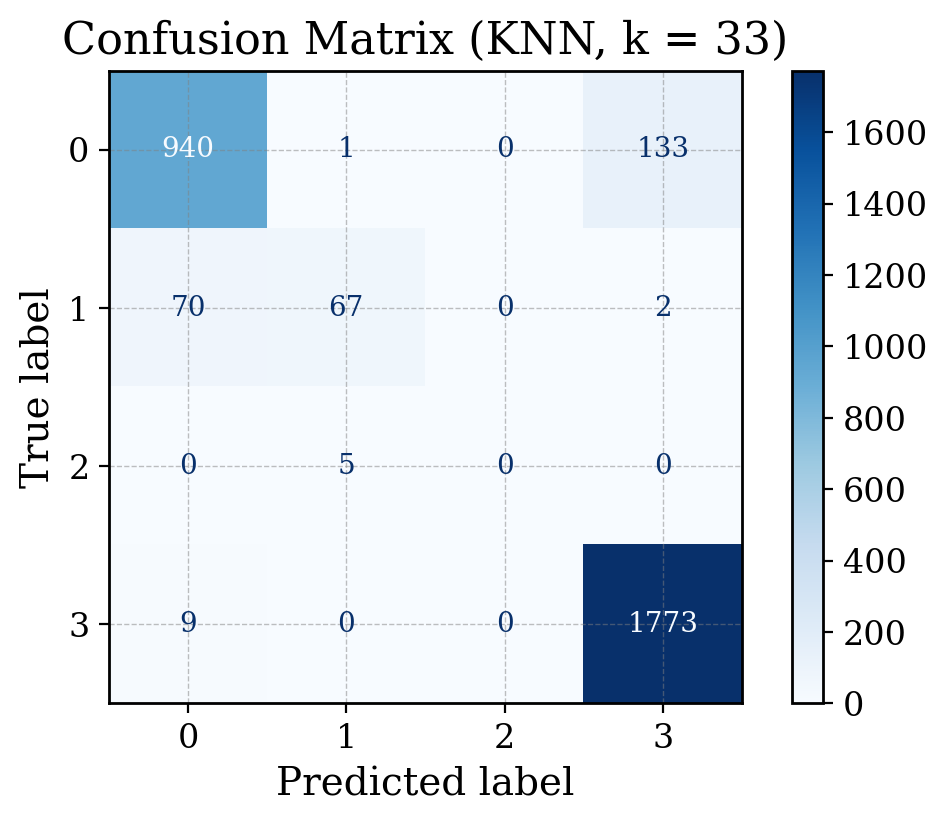

In [ ]:
k = 33

# Train a KNN classifier
knn = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])

knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

# Print/plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", cm)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (KNN, k = 33)")
plt.show()    

In [ ]:
#Multidimensional KNN, with Age, Coffee Intake, Sleep hours, BMI as features

X_train = train_df[["Age","Sleep_Hours", "Coffee_Intake", "BMI"]].to_numpy(copy=True)
y_train = train_df["Health_Issues"].to_numpy(copy=True)

X_val = val_df[["Age","Sleep_Hours", "Coffee_Intake", "BMI"]].to_numpy(copy=True)
y_val = val_df["Health_Issues"].to_numpy(copy=True)

In [ ]:
X = X_train.copy()

hmm = list(range(1,101,2))
acc = []
for k in hmm:
    # Train a KNN classifier
    knn = Pipeline([
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])

    knn.fit(X_train, y_train)

    # Predict
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    acc.append(accuracy)

#print(f'Model Accuracy: {accuracy:.2f}')

print(f'Best Model Accuracy: {max(acc):.2f} for k={2*np.argmax(acc)+1}')

Best Model Accuracy: 0.94 for k=7


Text(0.5, 1.0, 'Average MSE')

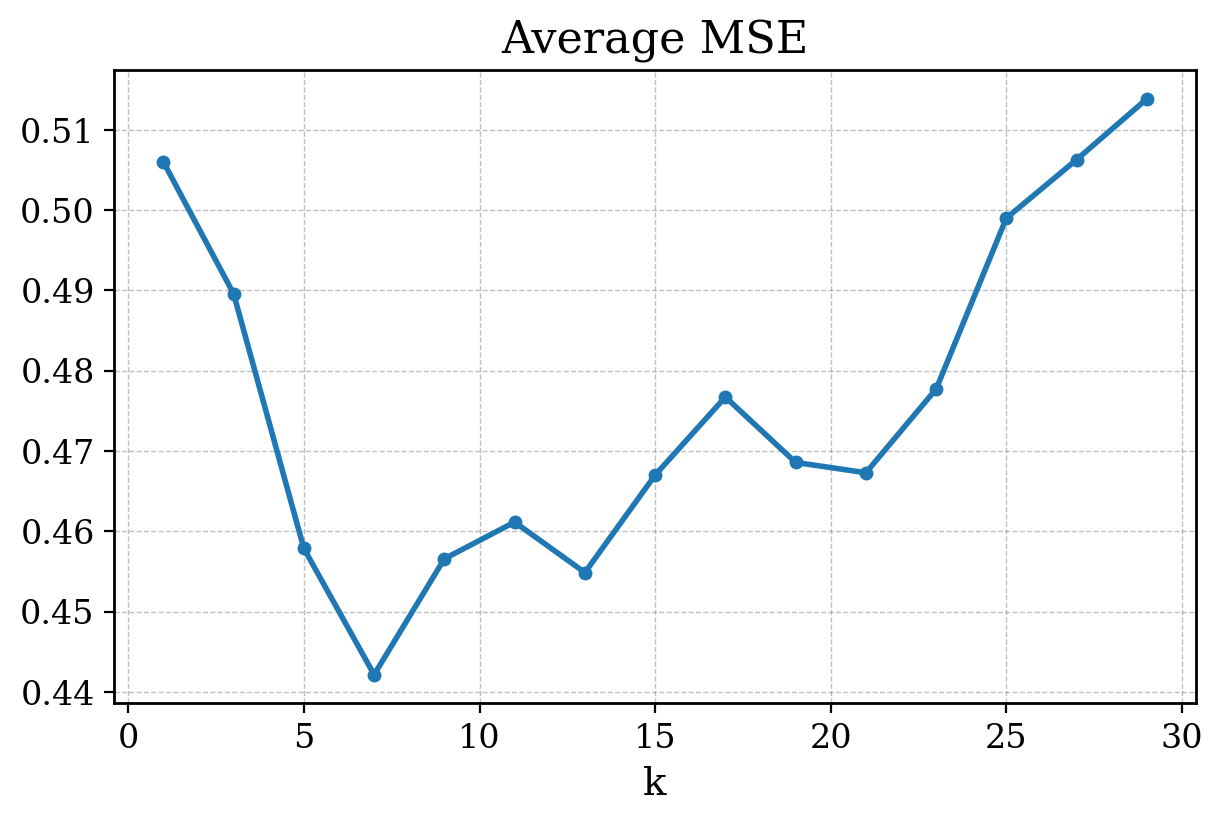

In [ ]:
class SklearnKNNRegressor:
    def __init__(self, k=3):
        self.k = k
        
        # Create the pipeline
        self.model = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=self.k))
        ])

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    # Plotting function
    def plot(self, x_train, y_train, x_pred, y_pred, k):
        plt.figure()
        plt.scatter(x_train, y_train, s=50, color=colors[7], edgecolors='k', alpha=0.4, label="Training noisy data")
        plt.plot(x_pred, y_pred, color=colors[1], label=f"kNN Prediction (k={k})")

        # Customize plot appearance
        plt.xlabel("Time (s)", fontsize=14)
        plt.ylabel("Displacement (m)", fontsize=14)
        plt.title(f"kNN Prediction (k={k})", fontsize=16)
        plt.grid(True)
        plt.legend()
        plt.show()

# ========== MAIN ==========   
hmm = list(range(1, 31, 2))
avg = []
for k in hmm:
    # Instantiate and use the sklearn-based kNN regressor
    sklearn_knn_model = SklearnKNNRegressor(k)
    sklearn_knn_model.fit(X_train, y_train)

    # Cross Validation
    cv_scores = cross_val_score(sklearn_knn_model.model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_scores *= -1  # Convert negative MSE to positive MSE
    avg.append(np.mean(cv_scores))
plt.plot(hmm,avg,marker=".")
plt.xlabel("k")
plt.title("Average MSE")

Confusion Matrix: 
 [[ 984   18    0   72]
 [  45   91    0    3]
 [   2    3    0    0]
 [  64    1    0 1717]]


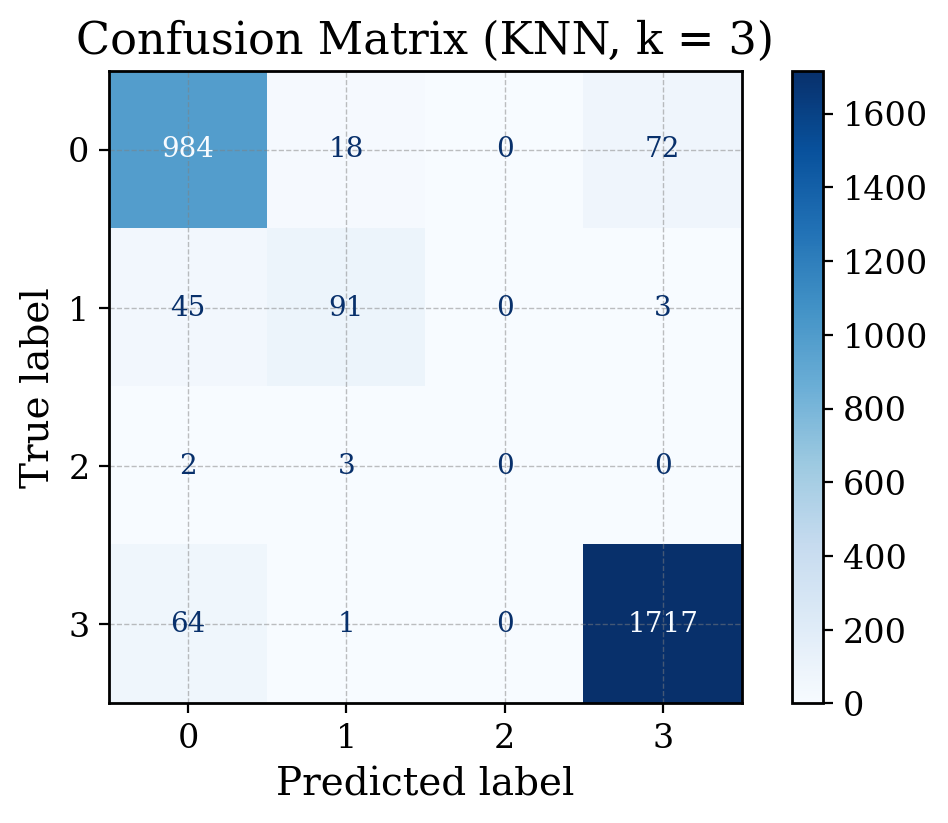

In [ ]:
k = 3

# Train a KNN classifier
knn = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])

knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

# Print/plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", cm)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (KNN, k = 3)")
plt.show()    

In [ ]:
#Ensemble Learning: RandomForest/XGBoost with all features

# This class is designed to compare various classifiers on a given dataset.
class ClassifierComparison:
    def __init__(self, X, y, test_size=0.3, use_bootstrap=True, random_state=42):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)
        
        # Scale features
        scaler       = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.X_test  = scaler.transform(X_test)

        # Take local copies for later use
        self.y_train = y_train
        self.y_test  = y_test
        self.use_bootstrap = use_bootstrap
        self.models     = {}
        self.results    = {}
        self.results_df = None

    def fit_models(self):
        # Define the classifiers to be compared
        self.models = {
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, bootstrap=self.use_bootstrap, random_state=42),
            'Bagging' : BaggingClassifier(n_estimators=100, bootstrap=self.use_bootstrap, random_state=42),
            'AdaBoost': AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'XGBoost' : XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42),
            'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
            'CatBoost': CatBoostClassifier(verbose=0, iterations=100, random_state=42)
        }

        results_list = [] # List to store results for DataFrame

        for name, model in self.models.items():
            # tic-toc the training and prediction time
            start_time_train = time.time()          # start the timer for training
            model.fit(self.X_train, self.y_train)   # train the model
            end_time_train = time.time()            # stop the timer for training
            
            start_time_pred = end_time_train        # start the timer for prediction
            y_pred = model.predict(self.X_test)     # make predictions
            end_time_pred = time.time()             # stop the timer for prediction

            # Calculate metrics and run time
            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Training Time (s)': (end_time_train - start_time_train),
                'Prediction Time (s)': (end_time_pred - start_time_pred),
                'Total Time (s)': (end_time_pred - start_time_train)
            }

            self.results[name] = {
                'model': model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            results_list.append(metrics)

        # Create a DataFrame from the results list
        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n")
        print("------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n")
        print("------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    def plot_confusion_matrices(self):
        for name, result in self.results.items():
            disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'])
            disp.plot()
            plt.title(f"Confusion Matrix: {name}")
            plt.show()

    # Plot decision boundaries for 2 features of different classifiers.
    # The default feature indices are (0, 1), but you can specify any two features.
    def plot_decision_boundaries(self, feature_indices=(0, 1)):
        i, j = feature_indices
        if self.X_train.shape[1] < 2:
            print("Decision boundary plot requires at least 2 features.")
            return

        h = 0.01
        x_min, x_max = self.X_train[:, i].min() - 0.5, self.X_train[:, i].max() + 0.5
        y_min, y_max = self.X_train[:, j].min() - 0.5, self.X_train[:, j].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        X_vis = np.zeros((xx.size, self.X_train.shape[1]))
        X_vis[:, i] = xx.ravel()
        X_vis[:, j] = yy.ravel()

        for name, result in self.results.items():
            model = result['model']
            # Predict the decision boundary. 
            # We use try-except to handle any potential errors during prediction.
            # Google the "try-except" in Python and learn it.
            try:
                prd = model.predict(X_vis)
                prd = prd.reshape(xx.shape)
                
                # Create a colormap for the regions
                region_cmap = ListedColormap(colors[:len(np.unique(self.y_train))])
                point_colors = np.array(colors)[self.y_train]

                plt.figure()
                plt.contourf(xx, yy, prd, alpha=0.3, cmap=region_cmap)
                plt.scatter(self.X_train[:, i], self.X_train[:, j],
                            c=point_colors, edgecolor='k', s=40, alpha=0.8)
                plt.xlabel("$x_{i}$", fontsize=14)
                plt.ylabel("$x_{j}$", fontsize=14)
                plt.title(f"Decision Boundary: {name} (Features x{i} vs x{j})")
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.show()
            except Exception as e:
                print(f"Skipping {name}: failed to predict decision boundary. Error: {e}")

In [ ]:
# Create an instance of ClassifierComparison and fit the models

drop_feat = ["Health_Issues"]

feature_names = train_df.select_dtypes(include=["number"]).drop(columns=drop_feat).columns

X_train = train_df[feature_names].values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val = val_df[feature_names].values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

clf = ClassifierComparison(X_train, y_train)
clf.fit_models()

/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 4900, number of used features: 7
[LightGBM] [Info] Start training from score -1.027336
[LightGBM] [Info] Start training from score -3.072040
[LightGBM] [Info] Start training from score -6.417549
[LightGBM] [Info] Start training from score -0.520739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
clf.print_summary()



------ Results Sorted by Accuracy ------
            Model  Accuracy  Precision   Recall  F1 Score  Training Time (s)  Prediction Time (s)  Total Time (s)
         CatBoost  0.998571   0.998577 0.998571  0.998571           0.132840             0.002142        0.134982
    Decision Tree  0.998095   0.998096 0.998095  0.998095           0.007097             0.000495        0.007592
          Bagging  0.998095   0.998099 0.998095  0.998096           0.290047             0.004438        0.294485
    Random Forest  0.996190   0.996235 0.996190  0.995774           0.168461             0.005676        0.174137
Gradient Boosting  0.996190   0.994316 0.996190  0.995248           1.216906             0.004061        1.220967
         LightGBM  0.996190   0.996255 0.996190  0.995782           1.043615             0.005378        1.048993
          XGBoost  0.995238   0.995319 0.995238  0.994837           0.255006             0.000918        0.255924
         AdaBoost  0.401905   0.178371 0.4019

In [ ]:
class ClassifierComparisonOpt:
    def __init__(self, X, y, test_size=0.3, use_bootstrap=True, random_state=42, cv_folds=5):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)

        # Scale features
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.X_test  = scaler.transform(X_test)

        self.y_train       = y_train
        self.y_test        = y_test
        self.use_bootstrap = use_bootstrap
        self.cv_folds      = cv_folds
        self.models        = {}
        self.results       = {}
        self.results_df    = None

    # Define the classifiers and their hyperparameters
    def get_models_with_params(self):
        return {
            'Decision Tree': (DecisionTreeClassifier(random_state=42), {
                'max_depth': [None, 3, 5, 10, 20],
                'min_samples_split': [2, 5, 7, 10]
            }),
            'Random Forest': (RandomForestClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 3, 5, 10, 20],
                'min_samples_split': [2, 5, 7, 10]
            }),
            'Bagging': (BaggingClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_samples': [0.5, 1.0],
                'oob_score': [True, False],
            }),
            # SAMME: Stagewise Additive Modeling using a Multi-class Exponential loss
            'AdaBoost': (AdaBoostClassifier(algorithm='SAMME', random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]
            }),
            'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                'max_depth': [3, 5, 10]
            }),
            'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                'max_depth': [3, 5, 10]
            }),
            #'LightGBM': (LGBMClassifier(random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'max_depth': [-1, 5, 10]
            #}),
            #'CatBoost': (CatBoostClassifier(verbose=0, random_state=42), {
            #    'iterations': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'depth': [4, 6, 10]
            #})
        }

    def fit_models(self):
        results_list = []
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        models_with_params = self.get_models_with_params()

        for name, (model, param_grid) in models_with_params.items():
            print(f"Tuning {name} ...")
            
            grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
            
            start_train = time.time()
            grid_search.fit(self.X_train, self.y_train)
            end_train = time.time()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)
            end_pred = time.time()

            self.models[name] = {
                'model': best_model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Best Params': grid_search.best_params_,
                'Training Time (s)': (end_train - start_train),
                'Prediction Time (s)': (end_pred - end_train),
                'Total Time (s)': (end_pred - start_train)
            }

            results_list.append(metrics)

        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    # Show feature importance for models that support it          
    def show_feature_importance(self):
        importance = {}

        for name, result in self.models.items():
            model = result['model']
            if hasattr(model, 'feature_importances_'):
                importance[name] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                coef = model.coef_
                if coef.ndim == 1:
                    importance[name] = np.abs(coef)
                else:
                    importance[name] = np.mean(np.abs(coef), axis=0)
            else:
                print(f"Feature importance not available for model {name}")

        for name, imp in importance.items():
            sorted_idx = np.argsort(imp)[::-1]
            plt.figure()
            plt.bar(range(len(imp)), imp[sorted_idx], align='center')
            plt.xticks(range(len(imp)), sorted_idx)
            plt.title(f"Feature importance for {name}")
            plt.xlabel("Feature index")
            plt.ylabel("Importance score")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()

clf_opt = ClassifierComparisonOpt(X_train, y_train)
clf_opt.fit_models()

Tuning Decision Tree ...
Tuning Random Forest ...
Tuning Bagging ...
Tuning AdaBoost ...


/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/dustinseboldt/Desktop

Tuning Gradient Boosting ...
Tuning XGBoost ...


In [ ]:
#Print the summary of results
clf_opt.print_summary()


------ Results Sorted by Accuracy ------
            Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
    Decision Tree  0.998095   0.998096 0.998095  0.998095                     {'max_depth': None, 'min_samples_split': 5}           0.103876             0.000121        0.103997
          Bagging  0.998095   0.998105 0.998095  0.998092     {'max_samples': 0.5, 'n_estimators': 50, 'oob_score': True}           2.902877             0.002515        2.905392
    Random Forest  0.997619   0.997634 0.997619  0.997465 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}           7.069752             0.003039        7.072791
Gradient Boosting  0.995714   0.993814 0.995714  0.994761      {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}          32.857616             0.002232       32.859848
          XGBoost  0.995714   0.995752 0.995714  0.995296     {'lear

Feature importance not available for model Bagging


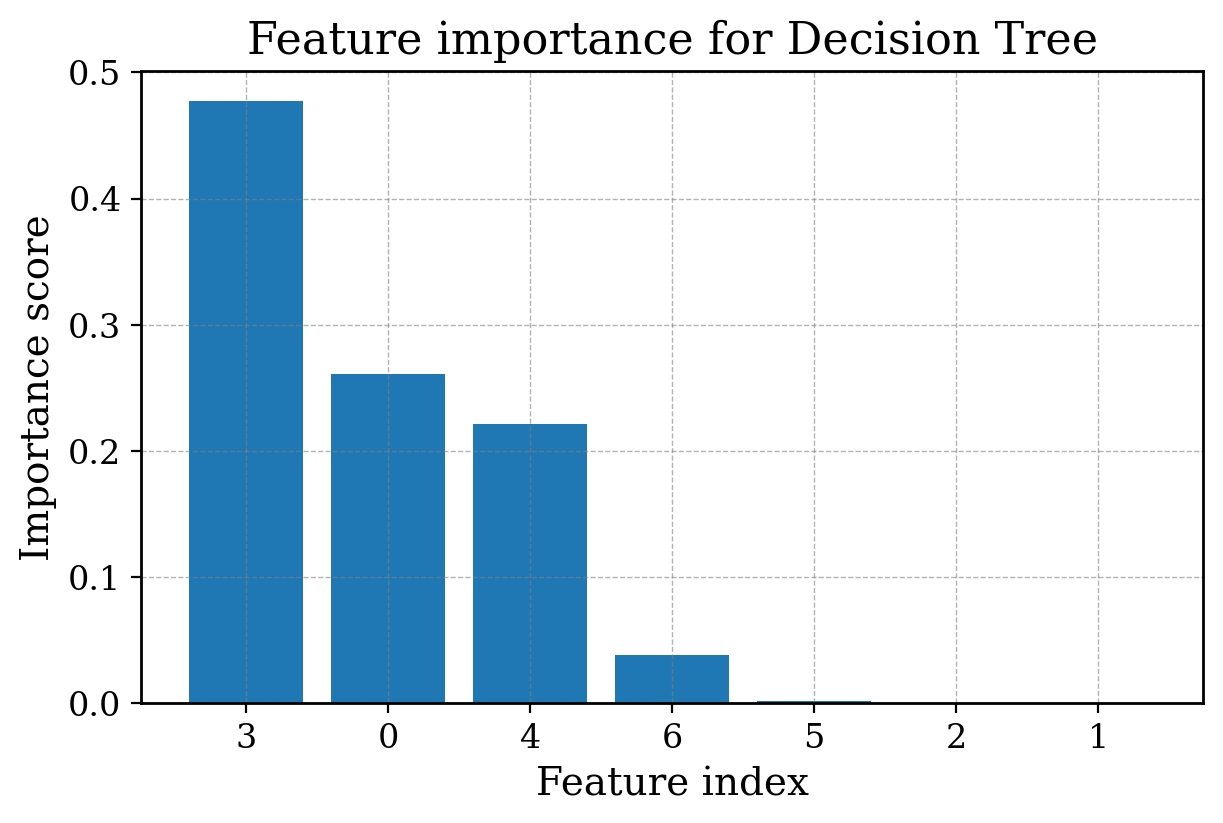

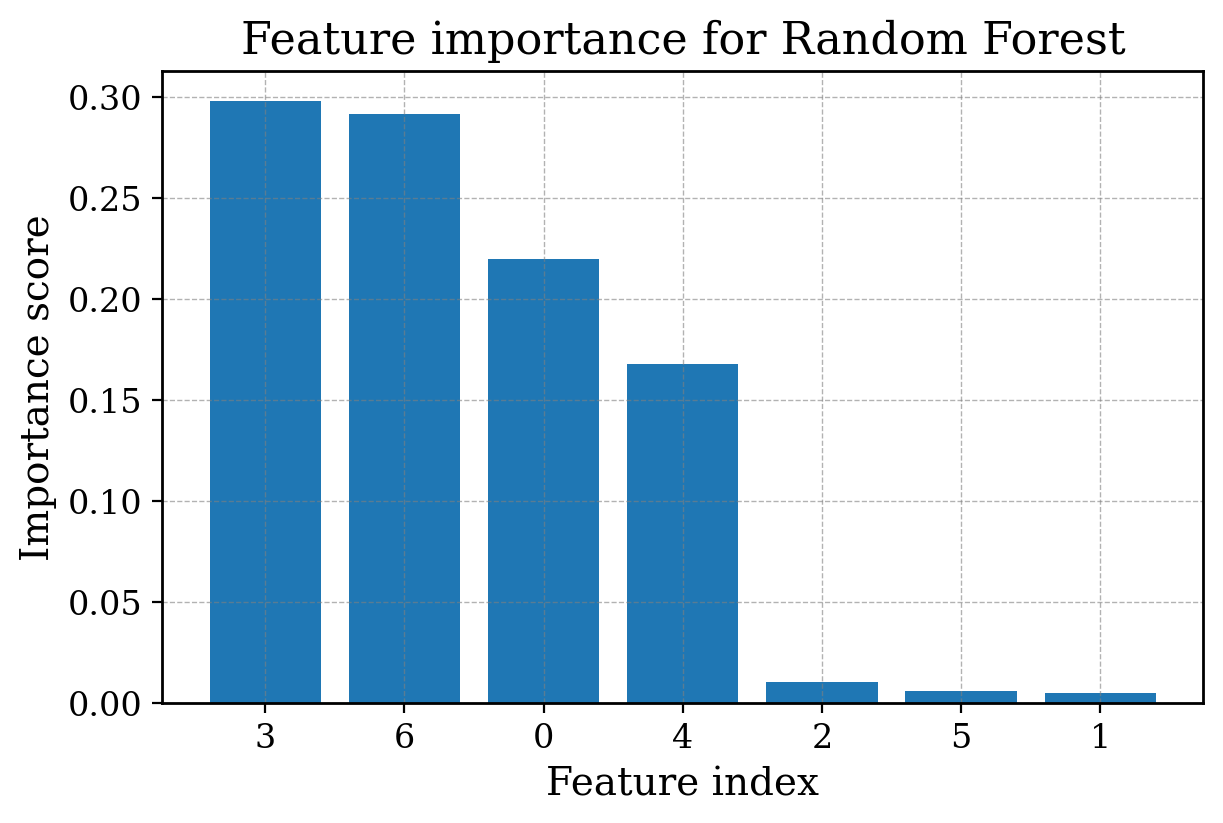

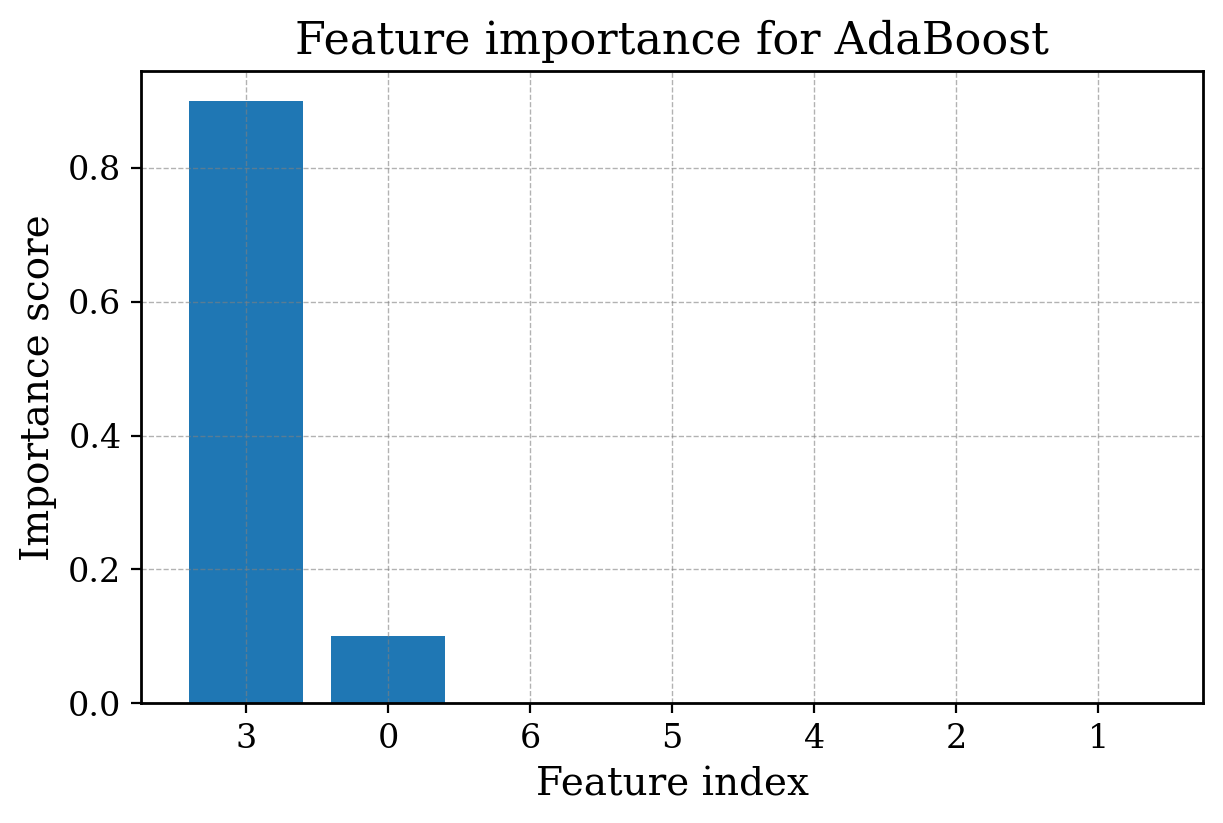

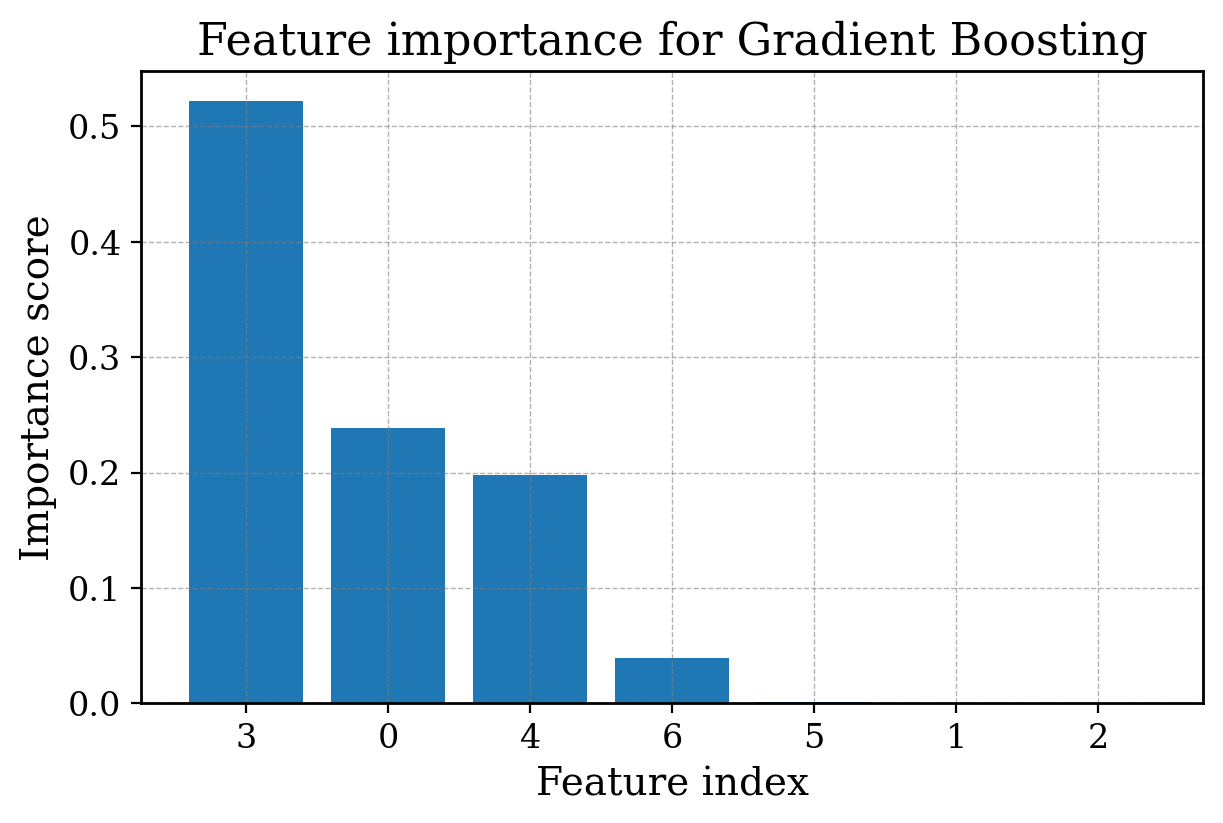

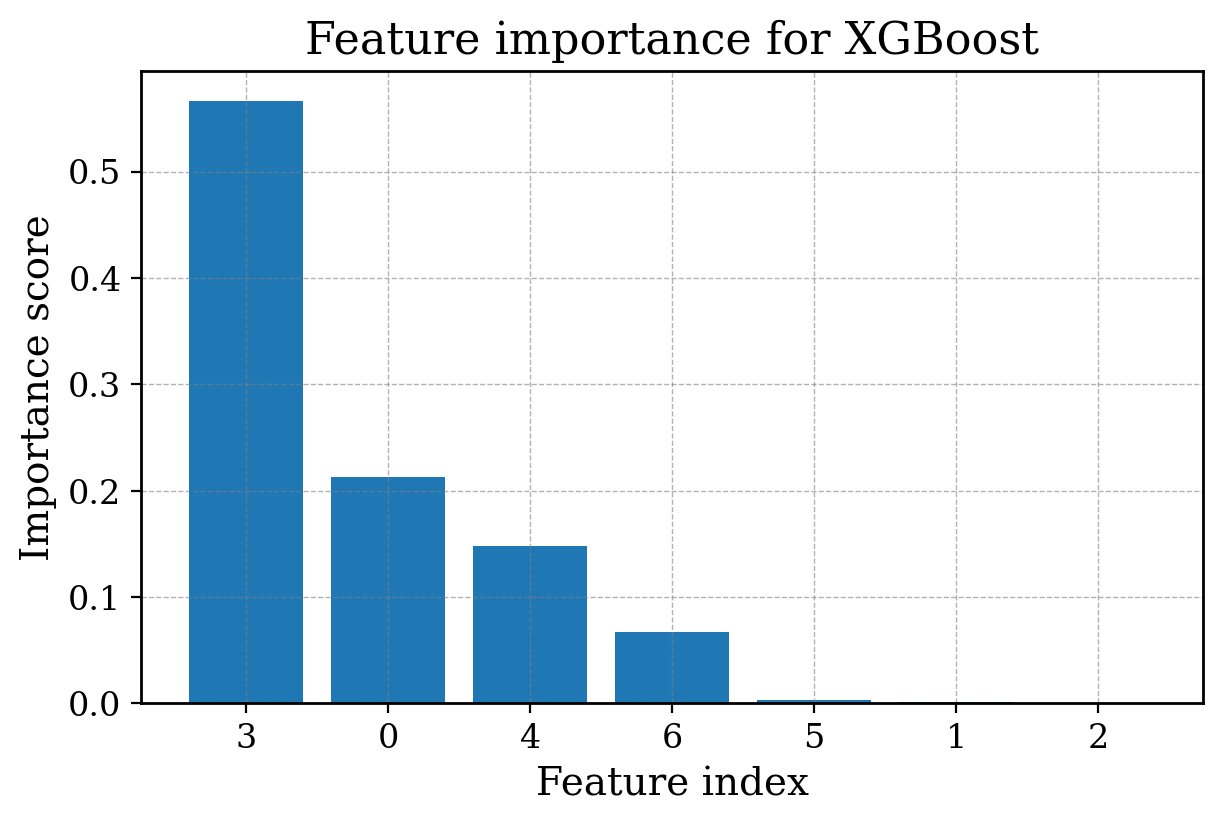

In [ ]:
# Show feature importance for each model
clf_opt.show_feature_importance()

In [ ]:
feature_names = train_df.select_dtypes(include=["number"]).drop(columns=drop_feat).columns

X_train_origin = train_df[feature_names].values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val_origin = val_df[feature_names].values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test sets
X_train = scaler.fit_transform(X_train_origin)
X_val  = scaler.transform(X_val_origin)

In [ ]:
#Multilayer Perceptron

# Import required libraries for building the MLP model
from tensorflow import keras
from tensorflow.keras import layers

# We need to convert the labels to one-hot encoded format for multi-class classification,
# and we should do it only once. Therefore, we use a flag variable `already_converted` to check 
# if the conversion has been done. The `already_converted` variable is defined in a try-except block to avoid
# re-initialization if it already exists in the notebook's global scope.
from tensorflow.keras.utils import to_categorical

already_converted = False

try:
    already_converted
except NameError:
    already_converted = False
print(already_converted)

if not already_converted:
    y_train = to_categorical(y_train, 4)
    y_val  = to_categorical(y_val, 4)
    already_converted = True

False


In [ ]:
# Build the model
mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(7,)),  # Hidden layer 1
    layers.Dense(64, activation='relu'),                      # Hidden layer 2
    layers.Dense(4, activation='softmax')                    # Output layer (10 classes)
])

# Compile the model
mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)

/Users/dustinseboldt/Desktop/mlp/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
train_history = mlp_model.fit(
    X_train, y_train,
    epochs=100,          # Number of epochs to train the model
    batch_size=512,     # Number of samples per gradient update
    validation_data=(X_val, y_val) )

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5551 - loss: 1.2102 - val_accuracy: 0.7433 - val_loss: 0.8952
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - loss: 0.7552 - val_accuracy: 0.8280 - val_loss: 0.6195
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8314 - loss: 0.5726 - val_accuracy: 0.8410 - val_loss: 0.5068
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8440 - loss: 0.4865 - val_accuracy: 0.8493 - val_loss: 0.4383
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.4254 - val_accuracy: 0.8660 - val_loss: 0.3860
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3764 - val_accuracy: 0.8773 - val_loss: 0.3429
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8803 - loss: 0.3355 - val_accuracy: 0.8907 - val_loss: 0.3076
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8916 - loss: 0.3025 - val_accuracy: 0.9033 - v

In [ ]:
# Evaluate the model
test_loss, test_acc = mlp_model.evaluate(X_val, y_val)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.9880 - loss: 0.0340
Test loss: 0.0340
Test accuracy: 0.9880


In [ ]:
# View model summary
mlp_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,622 (111.81 KB)

 Trainable params: 9,540 (37.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,082 (74.54 KB)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


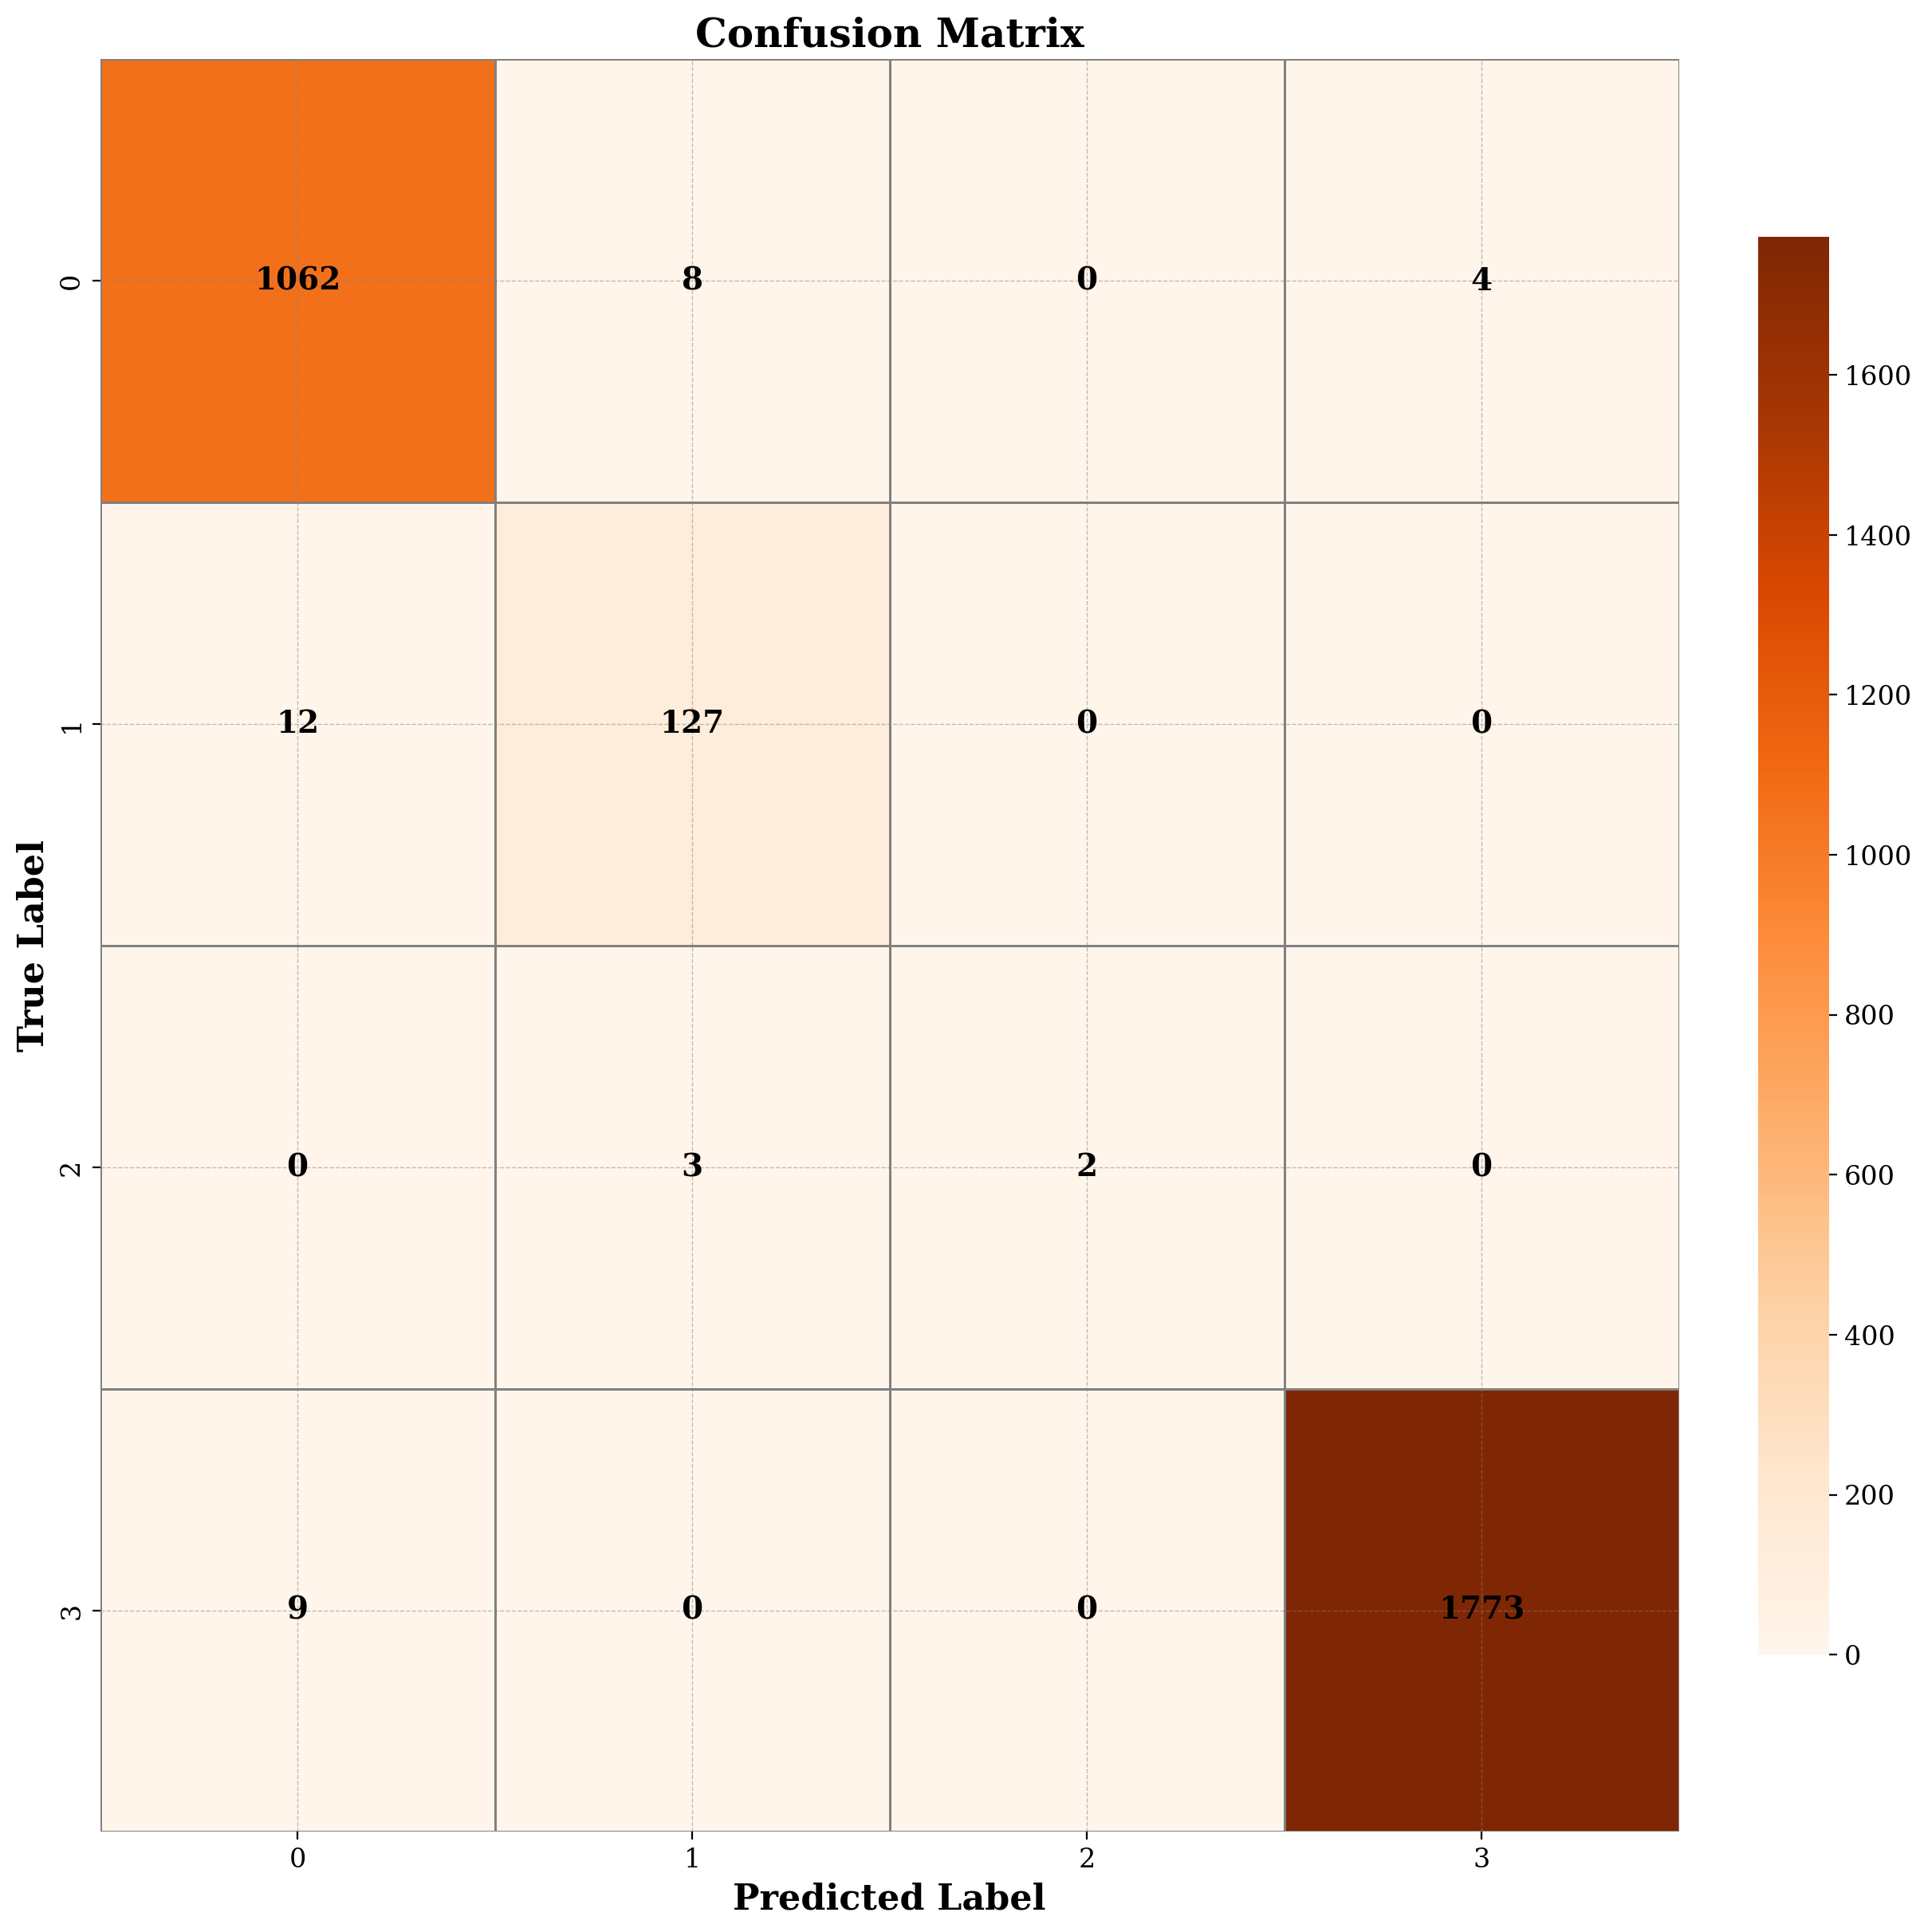

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions (class indices)
y_pred_probs = mlp_model.predict(X_val)       # shape (14000, 10)
y_pred_mlp   = np.argmax(y_pred_probs, axis=1)     # convert from one-hot probabilities → class labels

# Get true labels
# If your y_test is one-hot encoded:
if y_val.ndim == 2 and y_val.shape[1] == 4:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Generate the confusion matrix
cm_mlp = confusion_matrix(y_true, y_pred_mlp)   # Compute the confusion matrix for the MLP predictions

# Plot the confusion matrix with improved aesthetics
plt.figure(figsize=(12, 12))
sns.heatmap(cm_mlp, 
            annot=True, fmt='d', cmap='Oranges', 
            linewidths=0.5,  # Add lines between cells
            linecolor='gray',  # Change the color of the lines
            cbar_kws={"shrink": 0.8},  # Adjust the color bar size
            annot_kws={"size": 14, "weight": "bold", "color": "black"})  # Customize annotation text

plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')

plt.show()
